# Image Classification

In this tutorial, we are going to build a neural network that can classify handwritten digits (0-9)! Does that sound exciting? Probabbly not in this problem domain. However the principles we are going to apply in handwritten digit recognition are equally valid to other visual recognition challanges. Would you like to build a 1000 class image classifier? Are you developing an automated vehicle? Do you want to replicate the human visual system? Read on.

*Disclaimer: the latter two objectives are far more complicated than this tutorial makes vision seem to be. It is almost abusive to consider human vision as simple as convolution.*

### Notice and Copyright

This tutorial was written to complete the Quiz 14 requirement of Data Mining:

> Complete the MNIST Classifier shown in class and submit the code+output screenshot.
> 
> Change the network to contain 4 convolution layers with 6, 32, 64, 16 layers, and 3 fully connected layers with 256, 64, 10 nodes in each layer respectively.
> 
> Use sigmoid activation in all layers except the output layer.

And later extended for the Assignment 1 requirement of the same class:

> Your goal is building CIFAR-10 image classifier.

All comments and code were written from memory. No papers, books, Google, stack overflow, or Internet unless noted.

Copyright &copy; Jacob Valdez 2021. Released under MIT License.

## Getting Started

As you start to explore github, you'll observe a few common nicknames that we give our packages. I'm just going to import my default go-to's for now:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as display

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as tfkl
import tensorflow.keras.datasets as datasets

## The Data

Let's load the `mnist` dataset and observe a few elements.

11501568/11490434 [==============================] - 0s 0us/step


5

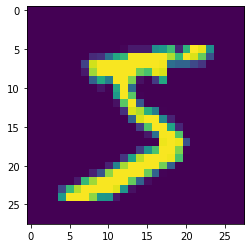

0

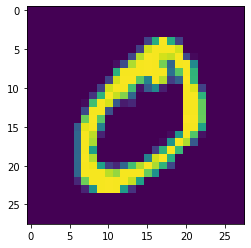

4

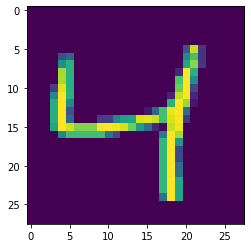

1

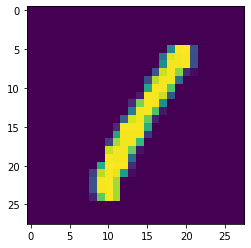

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [ ]:
(X_train, Y_train), (X_test, Y_test) = datasets.mnist.load_data()

for i in range(4):
    plt.imshow(X_train[i])
    display.display(Y_train[i])
    plt.show()

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Notice that each number has an image (stored in `X_train/test`) and a label (stored in `Y_train/test`) Each image is 28 by 28 pixels and there are 60000 training examples and 10000 test examples. Note that this dataset is supplied in integers so I'm going to convert it to floating point representation for our neural network:

In [ ]:
print('before', X_train.dtype)
X_train, X_test = X_train/255., X_test/255.
print('after', X_train.dtype)

before uint8
after float64


## The Classifier

We're just going to build a plain-old Convolutional Neural Network. The idea of performing convolutions is that not every part of an images has information pertaining to every other part. As we analyze a scene, we can often decompose the visual information relationships into a spatially segmented hierarchy. Convolutional neural networks carry this inductive bias by performing a miniature perceptron operation at every receptive field location in an image. Unless commented below, we'll use keras's default implementations to achieve this:  

In [ ]:
model = keras.Sequential([
    tfkl.Input(shape=(28, 28)),
    tfkl.Reshape(target_shape=(28, 28, 1)),  # give each pixel a 1 dimensional channel
    tfkl.Conv2D(filters=6, kernel_size=(3,3), activation='sigmoid'),
    tfkl.Conv2D(filters=32, kernel_size=(3,3), activation='sigmoid'),
    tfkl.Conv2D(filters=64, kernel_size=(3,3), activation='sigmoid'),
    tfkl.Conv2D(filters=16, kernel_size=(3,3), activation='sigmoid'),
    tfkl.GlobalMaxPooling2D(),  # this layer will take the highest value features over all pixels for each of the 16 filters
    tfkl.Dense(256, activation='sigmoid'),
    tfkl.Dense(64, activation='sigmoid'),
    tfkl.Dense(10),
])

## Training

Next, we're goign to train our classifier. Since the data is supplied with integer labels but our model outputs probabilities over 10 classes, we cannot directly differentiate between the two without either
- converting `y_train` and `y_test` integer labels into one-hot encodings or
- using a sparse categorical loss function.

I select the latter option for computational and information theoretic reasons. Cross entropy $H(p,q)$ represents the expected amount of extra information needed to encode some code under an existing distribution. Formally, $$H(p,q)=E_{x \sim p(x)}[-\log{q(x)}]$$
This is ideal when our model serves as the posterier $q(x,y)$ and the dataset as the prior $p(x,y)$. Our loss function will then be the sparse categorical cross entropy between our model's estimates and the dataset labels. Keras provides a high level interface to implement this in the `model.compile` function:

In [ ]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 6)         60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        1760      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 16)        9232      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               4

Now it's time to actually train the model. Let's supply our training a testing data and see how training progresses:

In [ ]:
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=64,
    epochs=10,
    verbose=2,
    validation_data=(X_test, Y_test),
    validation_batch_size=64,
)

Epoch 1/10
938/938 - 22s - loss: 2.3095 - val_loss: 2.3083
Epoch 2/10
938/938 - 5s - loss: 2.0046 - val_loss: 1.8036
Epoch 3/10
938/938 - 5s - loss: 1.5575 - val_loss: 1.3240
Epoch 4/10
938/938 - 5s - loss: 1.0506 - val_loss: 0.8737
Epoch 5/10
938/938 - 5s - loss: 0.6946 - val_loss: 0.5424
Epoch 6/10
938/938 - 5s - loss: 0.5413 - val_loss: 0.5187
Epoch 7/10
938/938 - 5s - loss: 0.4601 - val_loss: 0.4580
Epoch 8/10
938/938 - 5s - loss: 0.3984 - val_loss: 0.3420
Epoch 9/10
938/938 - 5s - loss: 0.3344 - val_loss: 0.2832
Epoch 10/10
938/938 - 5s - loss: 0.2850 - val_loss: 0.2613


What's happening? The loss isn't improving. 

Why can't we just plug and chug whatever data we want into our model? Consider two reasons:
1) There is no globally optimal universal approximator, and specialized models such as this CNN may not have sufficient inductive priors to estimate their data generating distribution
2) Sigmoid-type activation functions saturate the gradients relatively easily. This means that when the input is large in the positive or negative extrema, gradients are effectively zero. During backpropagation, the gradients hardly penetrate the top layer and only slowly penetrate lower and lower into the model. (See the paper that introduced batch norm and *The Principles of Deep Learning Theory* for a longer discussion of these points.)

We can solve this problem by changing our activation function to something that is still nonlinear but allows gradients to flow faster over the epochs. My go-to activation function is the rectified linear unit `relu`:

In [ ]:
model = keras.Sequential([
    tfkl.Input(shape=(28, 28)),
    tfkl.Reshape(target_shape=(28, 28, 1)),  # give each pixel a 1 dimensional channel
    tfkl.Conv2D(filters=6, kernel_size=(3,3), activation='relu'),
    tfkl.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    tfkl.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tfkl.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    tfkl.GlobalMaxPooling2D(),  # this layer will take the highest value features over all pixels for each of the 16 filters
    tfkl.Dense(256, activation='relu'),
    tfkl.Dense(64, activation='relu'),
    tfkl.Dense(10),
])
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=64,
    epochs=10,
    verbose=2,
    validation_data=(X_test, Y_test),
    validation_batch_size=64,
)

Epoch 1/10
938/938 - 6s - loss: 0.6999 - val_loss: 0.3878
Epoch 2/10
938/938 - 5s - loss: 0.2282 - val_loss: 0.1778
Epoch 3/10
938/938 - 5s - loss: 0.1500 - val_loss: 0.1543
Epoch 4/10
938/938 - 5s - loss: 0.1216 - val_loss: 0.1268
Epoch 5/10
938/938 - 5s - loss: 0.1027 - val_loss: 0.0911
Epoch 6/10
938/938 - 5s - loss: 0.0929 - val_loss: 0.0902
Epoch 7/10
938/938 - 5s - loss: 0.0808 - val_loss: 0.0770
Epoch 8/10
938/938 - 5s - loss: 0.0733 - val_loss: 0.0844
Epoch 9/10
938/938 - 5s - loss: 0.0680 - val_loss: 0.0790
Epoch 10/10
938/938 - 5s - loss: 0.0632 - val_loss: 0.0964


What a significant change. `relu` definitely performed better in the first 10 epochs than `sigmoid`. Feel free to experiment yourself with this model.

In [ ]:
# your code here (download this notebook at https://raw.githubusercontent.com/JacobFV/jacobfv.github.io/source/notebooks/MNIST_Classifier.ipynb)

## How to Overfit Your Dev Set

I hope you've enjoyed learning about machine learning by tweaking the hyperparameters of your model. Likely you realize at this point that we could tweek hyperparameters forever. Why not let machine learn machine learning instead? [`ray-tune`](https://docs.ray.io/en/latest/tune/index.html) is a powerful tool we can use to find the optimal hyperparameters for a model. Per its official docs, `ray.tune` frames its optimization problem into a run -- report metric -- optimize iteration loop. To give you the idea, here's their [quick start code](https://docs.ray.io/en/latest/tune/index.html):

```python
from ray import tune


def objective(step, alpha, beta):
    return (0.1 + alpha * step / 100)**(-1) + beta * 0.1


def training_function(config):
    # Hyperparameters
    alpha, beta = config["alpha"], config["beta"]
    for step in range(10):
        # Iterative training function - can be any arbitrary training procedure.
        intermediate_score = objective(step, alpha, beta)
        # Feed the score back back to Tune.
        tune.report(mean_loss=intermediate_score)


analysis = tune.run(
    training_function,
    config={
        "alpha": tune.grid_search([0.001, 0.01, 0.1]),
        "beta": tune.choice([1, 2, 3])
    })

print("Best config: ", analysis.get_best_config(
    metric="mean_loss", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df
```

Let's make an isomorphic case with our MNIST classifier: We'll have a triple optimization loop. On the inside, `SGD`, `Adam`, `RMSProp`, or another first order optimizer will backpropagate gradients into the trainable parameters. After 10 epochs, a hyperparameter optimizer will tune our choice of activation function, hidden convolution and dense layers, hidden depth, loss function, and inner optimizer. Finally, we'll be the slow optimizer and make changes to the primary and secondary optimization loops when needed. Let's start by defining our meta-objective:

In [ ]:
# on a separate console run:
# pip install -q ray[tune]
# ray start --head --num-cpus 2 --num-gpus 1

import ray
import ray.tune as tune
ray.init(address='auto', _redis_password='5241590000000000')

2021-11-01 13:39:23,542	INFO worker.py:827 -- Connecting to existing Ray cluster at address: 10.138.0.10:6379


{'node_ip_address': '10.138.0.10',
 'raylet_ip_address': '10.138.0.10',
 'redis_address': '10.138.0.10:6379',
 'object_store_address': '/tmp/ray/session_2021-11-01_13-39-17_184816_6838/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-11-01_13-39-17_184816_6838/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2021-11-01_13-39-17_184816_6838',
 'metrics_export_port': 49266,
 'node_id': '06fd01adf83b504b561996944ea682fc4135d39c2ebd6199b713c524'}

### Iteration 1

In [ ]:
def meta_loss(config):

    # load dataset
    (X_train, Y_train), (X_test, Y_test) = datasets.mnist.load_data()
    X_train, X_test = X_train / 255., X_test / 255.
    

    # number of units in each layer (if applicable)
    N1 = config['N1']
    N2 = config['N2']
    N3 = config['N3']
    N4 = config['N4']
    N5 = config['N5']
    N6 = config['N6']
    N7 = config['N7']

    # layer type: conv2d, dense, maxpooling2d, flatten, dropout, none
    # exactly one flatten layer is allowed and conv2d must be placed before flatten
    # errors are indicated by massive negative losses
    L1 = config['L1'].lower()
    L2 = config['L2'].lower()
    L3 = config['L3'].lower()
    L4 = config['L4'].lower()
    L5 = config['L5'].lower()
    L6 = config['L6'].lower()
    L7 = config['L7'].lower()

    conv_activation = config['conv_activation'].lower()  # 'sigmoid', 'relu', 'tanh', 'elu', 'selu', 'softplus', 'softsign'
    dense_activation = config['dense_activation'].lower()  # 'sigmoid', 'relu', 'tanh', 'elu', 'selu', 'softplus', 'softsign'
    initial_learning_rate = 10 ** config['initial_learning_rate_exp']  # -4.0 to -1.0
    learning_rate_rate = 10 ** config['learning_rate_rate']  # 0.0 to 1.0
    optimizer_name = config['optimizer_name'].lower()  # 'adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', or 'nadam'
    batch_size = config['batch_size']  # 4 to 1024, integers only
    loss_name = config['loss_name'].lower()  # 'mse', 'mae', 'mape', 'categorical_crossentropy', or 'sparse_categorical_crossentropy'

    # activation functions
    activations = {
        'sigmoid': tf.nn.sigmoid,
        'relu': tf.nn.relu,
        'tanh': tf.nn.tanh,
        'elu': tf.nn.elu,
        'selu': tf.nn.selu,
        'softplus': tf.nn.softplus,
        'softsign': tf.nn.softsign,
    }
    conv_activation = activations[conv_activation]
    dense_activation = activations[dense_activation]

    # make the loss function
    losses = {
        'mse': keras.losses.MeanSquaredError(),
        'mae': keras.losses.MeanAbsoluteError(),
        'mape': keras.losses.MeanAbsolutePercentageError(),
        'categorical_crossentropy': keras.losses.CategoricalCrossentropy(),
        'sparse_categorical_crossentropy': keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    }
    loss = losses[loss_name]

    # convert labels to one-hot vectors for dense loss penalties
    if loss_name != 'spare_categorical_crossentropy':
        Y_train = tf.one_hot(Y_train, depth=10)
        Y_test = tf.one_hot(Y_test, depth=10)
    
    # optimizer and learning rate
    optimziers = {
        'SGD': keras.optimizers.SGD,
        'RMSprop': keras.optimizers.RMSprop,
        'Adagrad': keras.optimizers.Adagrad,
        'Adadelta': keras.optimizers.Adadelta,
        'Adam': keras.optimizers.Adam,
        'Adamax': keras.optimizers.Adamax,
        'Nadam': keras.optimizers.Nadam,
    }
    optimizer = optimziers[optimizer_name](initial_learning_rate)

    learning_rate_scheduler = keras.callbacks.LearningRateScheduler(
        lambda epoch, _: initial_learning_rate * (learning_rate_rate ** epoch))

    # build model
    model = keras.Sequential([
        tfkl.Input(shape=(28, 28)),
        tfkl.Reshape(target_shape=(28, 28, 1))  # give each pixel a 1 dimensional channel
    ])

    flattened = False
    for L, N in zip([L1, L2, L3, L4, L5, L6, L7], [N1, N2, N3, N4, N5, N6, N7]):
        if L == 'conv2d':
            if not flattened:
                model.add(tfkl.Conv2D(filters=N, kernel_size=(3,3), 
                                      activation=conv_activation))
        elif L == 'maxpooling2d':
            if not flattened:
                model.add(tfkl.MaxPooling2D(pool_size=(2,2)))
        elif L == 'flatten':
            if not flattened:
                model.add(tfkl.Flatten())
                flattened = True
        elif L == 'dropout':
            model.add(tfkl.Dropout(rate=0.1))
        elif L == 'dense':
            if flattened:
                model.add(tfkl.Dense(N, activation=dense_activation))
        elif L == 'none':  # no more hidden layers
            break
        else:
            raise ValueError(f'unknown layer type {L}')
    model.add(tfkl.Dense(10, activation='softmax'))  # softmax activation is used for classification
    model.compile(loss=loss, optimizer=optimizer)

    # train model
    history = model.fit(
        x=X_train,
        y=Y_train,
        batch_size=batch_size,
        epochs=10,
        verbose=2,
        callbacks=[learning_rate_scheduler],
        validation_data=(X_test, Y_test),
        validation_batch_size=64,
    )

    # report validation loss
    final_val_loss = history.history['val_loss'][-1]
    tune.report(validation_loss=final_val_loss)

Now just looking at the hyperparameter space we've defined, you can see why this is overkill for MNIST. Each run of `meta_loss` runs a full 10 iterations on the optimization loop beneath it. To meet these computation demands, I'm running this notebook on a deep learning optimized Google Cloud VM (n1-highmem-2 with an nvidia-tesla-k80). Learn how you can do this on your own for AWS or GCP from my [previous notebook](https://jacobfv.github.io/blog/rtc-jupyterlab-in-the-cloud/).

Without further hesitation (the assignment due date is approaching), let's start tuning!

In [ ]:
analysis = tune.run(
    meta_loss,
    resources_per_trial={'gpu': 1},
    config={
        'N1': tune.grid_search([8, 10, 12, 16, 20, 32, 64, 96, 128, 192, 256]),
        'N2': tune.grid_search([8, 10, 12, 16, 20, 32, 64, 96, 128, 192, 256]),
        'N3': tune.grid_search([8, 10, 12, 16, 20, 32, 64, 96, 128, 192, 256]),
        'N4': tune.grid_search([8, 10, 12, 16, 20, 32, 64, 96, 128, 192, 256]),
        'N5': tune.grid_search([8, 10, 12, 16, 20, 32, 64, 96, 128, 192, 256]),
        'N6': tune.grid_search([8, 10, 12, 16, 20, 32, 64, 96, 128, 192, 256]),
        'N7': tune.grid_search([8, 10, 12, 16, 20, 32, 64, 96, 128, 192, 256]),
        'L1': tune.grid_search(['conv2d', 'dense', 'maxpooling2d', 'flatten', 'dropout', 'none']),
        'L2': tune.grid_search(['conv2d', 'dense', 'maxpooling2d', 'flatten', 'dropout', 'none']),
        'L3': tune.grid_search(['conv2d', 'dense', 'maxpooling2d', 'flatten', 'dropout', 'none']),
        'L4': tune.grid_search(['conv2d', 'dense', 'maxpooling2d', 'flatten', 'dropout', 'none']),
        'L5': tune.grid_search(['conv2d', 'dense', 'maxpooling2d', 'flatten', 'dropout', 'none']),
        'L6': tune.grid_search(['conv2d', 'dense', 'maxpooling2d', 'flatten', 'dropout', 'none']),
        'L7': tune.grid_search(['conv2d', 'dense', 'maxpooling2d', 'flatten', 'dropout', 'none']),
        'dense_activation': tune.grid_search(['sigmoid', 'relu', 'tanh', 'elu', 'selu', 'softplus', 'softsign']),
        'conv_activation': tune.grid_search(['sigmoid', 'relu', 'tanh', 'elu', 'selu', 'softplus', 'softsign']),
        'initial_learning_rate_exp': tune.uniform(-4.0, -1.0),
        'learning_rate_rate': tune.uniform(0.0, 1.0),
        'optimizer_name': tune.choice(['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']),
        'batch_size': tune.choice([4, 8, 16, 24, 32, 48, 64, 128]),
        'loss_name': tune.choice(['mse', 'mae', 'mape', 'categorical_crossentropy', 'sparse_categorical_crossentropy']),
    })

print("Best config: ", analysis.get_best_config(
    metric="val_loss", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df

2021-11-01 12:24:01,660	WARNING function_runner.py:559 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
/opt/conda/lib/python3.7/site-packages/ray/tune/suggest/basic_variant.py:289: UserWarning: The number of pre-generated samples (267302874351744) exceeds the serialization threshold (1000000). Resume ability is disabled. To fix this, reduce the number of dimensions/size of the provided grid search.
  f"The number of pre-generated samples ({grid_vals}) "


Trial name,status,loc,L1,L2,L3,L4,L5,L6,L7,N1,N2,N3,N4,N5,N6,N7,batch_size,conv_activation,dense_activation,initial_learning_rate_exp,learning_rate_rate,loss_name,optimizer_name
meta_loss_98963_00000,PENDING,,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-2.51525,0.553209,mape,adagrad
meta_loss_98963_00001,PENDING,,dense,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,16,sigmoid,sigmoid,-2.37358,0.314978,sparse_categorical_crossentropy,adagrad
meta_loss_98963_00002,PENDING,,maxpooling2d,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,128,sigmoid,sigmoid,-2.8581,0.512218,sparse_categorical_crossentropy,adamax
meta_loss_98963_00003,PENDING,,flatten,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,4,sigmoid,sigmoid,-1.27046,0.454703,mape,sgd
meta_loss_98963_00004,PENDING,,dropout,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,16,sigmoid,sigmoid,-3.53965,0.861406,categorical_crossentropy,adadelta
meta_loss_98963_00005,PENDING,,none,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,8,sigmoid,sigmoid,-3.50222,0.955176,mape,sgd
meta_loss_98963_00006,PENDING,,conv2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,128,sigmoid,sigmoid,-2.40886,0.878881,mae,adadelta
meta_loss_98963_00007,PENDING,,dense,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-1.66232,0.355708,mae,adagrad
meta_loss_98963_00008,PENDING,,maxpooling2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,64,sigmoid,sigmoid,-1.15489,0.736778,mae,nadam
meta_loss_98963_00009,PENDING,,flatten,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-2.96978,0.814146,categorical_crossentropy,adamax


(ImplicitFunc pid=1145) Downloading data from https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz
11501568/11490434 [==============================] - 0s 0us/step


Trial name,status,loc,L1,L2,L3,L4,L5,L6,L7,N1,N2,N3,N4,N5,N6,N7,batch_size,conv_activation,dense_activation,initial_learning_rate_exp,learning_rate_rate,loss_name,optimizer_name
meta_loss_98963_00000,RUNNING,,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-2.51525,0.553209,mape,adagrad
meta_loss_98963_00001,PENDING,,dense,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,16,sigmoid,sigmoid,-2.37358,0.314978,sparse_categorical_crossentropy,adagrad
meta_loss_98963_00002,PENDING,,maxpooling2d,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,128,sigmoid,sigmoid,-2.8581,0.512218,sparse_categorical_crossentropy,adamax
meta_loss_98963_00003,PENDING,,flatten,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,4,sigmoid,sigmoid,-1.27046,0.454703,mape,sgd
meta_loss_98963_00004,PENDING,,dropout,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,16,sigmoid,sigmoid,-3.53965,0.861406,categorical_crossentropy,adadelta
meta_loss_98963_00005,PENDING,,none,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,8,sigmoid,sigmoid,-3.50222,0.955176,mape,sgd
meta_loss_98963_00006,PENDING,,conv2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,128,sigmoid,sigmoid,-2.40886,0.878881,mae,adadelta
meta_loss_98963_00007,PENDING,,dense,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-1.66232,0.355708,mae,adagrad
meta_loss_98963_00008,PENDING,,maxpooling2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,64,sigmoid,sigmoid,-1.15489,0.736778,mae,nadam
meta_loss_98963_00009,PENDING,,flatten,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-2.96978,0.814146,categorical_crossentropy,adamax


(pid=1145) 2021-11-01 12:24:08.783944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=1145) 2021-11-01 12:24:08.941310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=1145) 2021-11-01 12:24:08.942175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=1145) 2021-11-01 12:24:08.944842: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=1145) To enable them in other operations,

Result for meta_loss_98963_00000:
  {}
  


Trial name,status,loc,L1,L2,L3,L4,L5,L6,L7,N1,N2,N3,N4,N5,N6,N7,batch_size,conv_activation,dense_activation,initial_learning_rate_exp,learning_rate_rate,loss_name,optimizer_name
meta_loss_98963_00001,RUNNING,,dense,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,16,sigmoid,sigmoid,-2.37358,0.314978,sparse_categorical_crossentropy,adagrad
meta_loss_98963_00002,PENDING,,maxpooling2d,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,128,sigmoid,sigmoid,-2.8581,0.512218,sparse_categorical_crossentropy,adamax
meta_loss_98963_00003,PENDING,,flatten,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,4,sigmoid,sigmoid,-1.27046,0.454703,mape,sgd
meta_loss_98963_00004,PENDING,,dropout,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,16,sigmoid,sigmoid,-3.53965,0.861406,categorical_crossentropy,adadelta
meta_loss_98963_00005,PENDING,,none,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,8,sigmoid,sigmoid,-3.50222,0.955176,mape,sgd
meta_loss_98963_00006,PENDING,,conv2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,128,sigmoid,sigmoid,-2.40886,0.878881,mae,adadelta
meta_loss_98963_00007,PENDING,,dense,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-1.66232,0.355708,mae,adagrad
meta_loss_98963_00008,PENDING,,maxpooling2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,64,sigmoid,sigmoid,-1.15489,0.736778,mae,nadam
meta_loss_98963_00009,PENDING,,flatten,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-2.96978,0.814146,categorical_crossentropy,adamax
meta_loss_98963_00010,PENDING,,dropout,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-1.84345,0.335166,sparse_categorical_crossentropy,adadelta


Trial name,status,loc,L1,L2,L3,L4,L5,L6,L7,N1,N2,N3,N4,N5,N6,N7,batch_size,conv_activation,dense_activation,initial_learning_rate_exp,learning_rate_rate,loss_name,optimizer_name
meta_loss_98963_00001,RUNNING,,dense,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,16,sigmoid,sigmoid,-2.37358,0.314978,sparse_categorical_crossentropy,adagrad
meta_loss_98963_00002,PENDING,,maxpooling2d,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,128,sigmoid,sigmoid,-2.8581,0.512218,sparse_categorical_crossentropy,adamax
meta_loss_98963_00003,PENDING,,flatten,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,4,sigmoid,sigmoid,-1.27046,0.454703,mape,sgd
meta_loss_98963_00004,PENDING,,dropout,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,16,sigmoid,sigmoid,-3.53965,0.861406,categorical_crossentropy,adadelta
meta_loss_98963_00005,PENDING,,none,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,8,sigmoid,sigmoid,-3.50222,0.955176,mape,sgd
meta_loss_98963_00006,PENDING,,conv2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,128,sigmoid,sigmoid,-2.40886,0.878881,mae,adadelta
meta_loss_98963_00007,PENDING,,dense,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-1.66232,0.355708,mae,adagrad
meta_loss_98963_00008,PENDING,,maxpooling2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,64,sigmoid,sigmoid,-1.15489,0.736778,mae,nadam
meta_loss_98963_00009,PENDING,,flatten,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-2.96978,0.814146,categorical_crossentropy,adamax
meta_loss_98963_00010,PENDING,,dropout,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-1.84345,0.335166,sparse_categorical_crossentropy,adadelta


(pid=1185) 2021-11-01 12:24:17.581494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=1185) 2021-11-01 12:24:17.592053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=1185) 2021-11-01 12:24:17.592853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=1185) 2021-11-01 12:24:17.594109: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=1185) To enable them in other operations,

Result for meta_loss_98963_00001:
  {}
  


Trial name,status,loc,L1,L2,L3,L4,L5,L6,L7,N1,N2,N3,N4,N5,N6,N7,batch_size,conv_activation,dense_activation,initial_learning_rate_exp,learning_rate_rate,loss_name,optimizer_name
meta_loss_98963_00002,RUNNING,,maxpooling2d,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,128,sigmoid,sigmoid,-2.8581,0.512218,sparse_categorical_crossentropy,adamax
meta_loss_98963_00003,PENDING,,flatten,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,4,sigmoid,sigmoid,-1.27046,0.454703,mape,sgd
meta_loss_98963_00004,PENDING,,dropout,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,16,sigmoid,sigmoid,-3.53965,0.861406,categorical_crossentropy,adadelta
meta_loss_98963_00005,PENDING,,none,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,8,sigmoid,sigmoid,-3.50222,0.955176,mape,sgd
meta_loss_98963_00006,PENDING,,conv2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,128,sigmoid,sigmoid,-2.40886,0.878881,mae,adadelta
meta_loss_98963_00007,PENDING,,dense,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-1.66232,0.355708,mae,adagrad
meta_loss_98963_00008,PENDING,,maxpooling2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,64,sigmoid,sigmoid,-1.15489,0.736778,mae,nadam
meta_loss_98963_00009,PENDING,,flatten,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-2.96978,0.814146,categorical_crossentropy,adamax
meta_loss_98963_00010,PENDING,,dropout,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-1.84345,0.335166,sparse_categorical_crossentropy,adadelta
meta_loss_98963_00011,PENDING,,none,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-3.12773,0.515024,categorical_crossentropy,adamax


(pid=1231) 2021-11-01 12:24:24.314833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=1231) 2021-11-01 12:24:24.325610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=1231) 2021-11-01 12:24:24.326377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=1231) 2021-11-01 12:24:24.328110: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=1231) To enable them in other operations,

Result for meta_loss_98963_00002:
  {}
  


Trial name,status,loc,L1,L2,L3,L4,L5,L6,L7,N1,N2,N3,N4,N5,N6,N7,batch_size,conv_activation,dense_activation,initial_learning_rate_exp,learning_rate_rate,loss_name,optimizer_name
meta_loss_98963_00003,RUNNING,,flatten,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,4,sigmoid,sigmoid,-1.27046,0.454703,mape,sgd
meta_loss_98963_00004,PENDING,,dropout,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,16,sigmoid,sigmoid,-3.53965,0.861406,categorical_crossentropy,adadelta
meta_loss_98963_00005,PENDING,,none,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,8,sigmoid,sigmoid,-3.50222,0.955176,mape,sgd
meta_loss_98963_00006,PENDING,,conv2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,128,sigmoid,sigmoid,-2.40886,0.878881,mae,adadelta
meta_loss_98963_00007,PENDING,,dense,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-1.66232,0.355708,mae,adagrad
meta_loss_98963_00008,PENDING,,maxpooling2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,64,sigmoid,sigmoid,-1.15489,0.736778,mae,nadam
meta_loss_98963_00009,PENDING,,flatten,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-2.96978,0.814146,categorical_crossentropy,adamax
meta_loss_98963_00010,PENDING,,dropout,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-1.84345,0.335166,sparse_categorical_crossentropy,adadelta
meta_loss_98963_00011,PENDING,,none,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-3.12773,0.515024,categorical_crossentropy,adamax
meta_loss_98963_00012,PENDING,,conv2d,maxpooling2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,8,sigmoid,sigmoid,-2.44683,0.949793,mse,adamax


(pid=1270) 2021-11-01 12:24:30.963152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=1270) 2021-11-01 12:24:30.973430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=1270) 2021-11-01 12:24:30.974169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=1270) 2021-11-01 12:24:30.975364: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=1270) To enable them in other operations,

Result for meta_loss_98963_00003:
  {}
  


Trial name,status,loc,L1,L2,L3,L4,L5,L6,L7,N1,N2,N3,N4,N5,N6,N7,batch_size,conv_activation,dense_activation,initial_learning_rate_exp,learning_rate_rate,loss_name,optimizer_name
meta_loss_98963_00004,RUNNING,,dropout,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,16,sigmoid,sigmoid,-3.53965,0.861406,categorical_crossentropy,adadelta
meta_loss_98963_00005,PENDING,,none,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,8,sigmoid,sigmoid,-3.50222,0.955176,mape,sgd
meta_loss_98963_00006,PENDING,,conv2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,128,sigmoid,sigmoid,-2.40886,0.878881,mae,adadelta
meta_loss_98963_00007,PENDING,,dense,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-1.66232,0.355708,mae,adagrad
meta_loss_98963_00008,PENDING,,maxpooling2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,64,sigmoid,sigmoid,-1.15489,0.736778,mae,nadam
meta_loss_98963_00009,PENDING,,flatten,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-2.96978,0.814146,categorical_crossentropy,adamax
meta_loss_98963_00010,PENDING,,dropout,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-1.84345,0.335166,sparse_categorical_crossentropy,adadelta
meta_loss_98963_00011,PENDING,,none,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-3.12773,0.515024,categorical_crossentropy,adamax
meta_loss_98963_00012,PENDING,,conv2d,maxpooling2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,8,sigmoid,sigmoid,-2.44683,0.949793,mse,adamax
meta_loss_98963_00013,PENDING,,dense,maxpooling2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-2.7508,0.0587266,categorical_crossentropy,nadam


Trial name,status,loc,L1,L2,L3,L4,L5,L6,L7,N1,N2,N3,N4,N5,N6,N7,batch_size,conv_activation,dense_activation,initial_learning_rate_exp,learning_rate_rate,loss_name,optimizer_name
meta_loss_98963_00004,RUNNING,,dropout,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,16,sigmoid,sigmoid,-3.53965,0.861406,categorical_crossentropy,adadelta
meta_loss_98963_00005,PENDING,,none,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,8,sigmoid,sigmoid,-3.50222,0.955176,mape,sgd
meta_loss_98963_00006,PENDING,,conv2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,128,sigmoid,sigmoid,-2.40886,0.878881,mae,adadelta
meta_loss_98963_00007,PENDING,,dense,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-1.66232,0.355708,mae,adagrad
meta_loss_98963_00008,PENDING,,maxpooling2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,64,sigmoid,sigmoid,-1.15489,0.736778,mae,nadam
meta_loss_98963_00009,PENDING,,flatten,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-2.96978,0.814146,categorical_crossentropy,adamax
meta_loss_98963_00010,PENDING,,dropout,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-1.84345,0.335166,sparse_categorical_crossentropy,adadelta
meta_loss_98963_00011,PENDING,,none,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-3.12773,0.515024,categorical_crossentropy,adamax
meta_loss_98963_00012,PENDING,,conv2d,maxpooling2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,8,sigmoid,sigmoid,-2.44683,0.949793,mse,adamax
meta_loss_98963_00013,PENDING,,dense,maxpooling2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-2.7508,0.0587266,categorical_crossentropy,nadam


(pid=1308) 2021-11-01 12:24:37.617787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=1308) 2021-11-01 12:24:37.629614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=1308) 2021-11-01 12:24:37.630415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=1308) 2021-11-01 12:24:37.631673: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=1308) To enable them in other operations,

Result for meta_loss_98963_00004:
  {}
  


2021-11-01 12:24:40,402	WARNING worker.py:1227 -- The autoscaler failed with the following error:
Terminated with signal 15
  File "/opt/conda/lib/python3.7/site-packages/ray/autoscaler/_private/monitor.py", line 430, in <module>
    monitor.run()
  File "/opt/conda/lib/python3.7/site-packages/ray/autoscaler/_private/monitor.py", line 331, in run
    self._run()
  File "/opt/conda/lib/python3.7/site-packages/ray/autoscaler/_private/monitor.py", line 248, in _run
    time.sleep(AUTOSCALER_UPDATE_INTERVAL_S)

2021-11-01 12:24:40,508	ERROR worker.py:1229 -- listen_error_messages_raylet: Connection closed by server.
2021-11-01 12:24:40,511	ERROR import_thread.py:88 -- ImportThread: Connection closed by server.
2021-11-01 12:24:40,517	ERROR worker.py:475 -- print_logs: Connection closed by server.
2021-11-01 12:24:40,545	ERROR ray_trial_executor.py:600 -- Trial meta_loss_98963_00006: Unexpected error starting runner.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-p

Trial name,status,loc,L1,L2,L3,L4,L5,L6,L7,N1,N2,N3,N4,N5,N6,N7,batch_size,conv_activation,dense_activation,initial_learning_rate_exp,learning_rate_rate,loss_name,optimizer_name
meta_loss_98963_00005,RUNNING,,none,conv2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,8,sigmoid,sigmoid,-3.50222,0.955176,mape,sgd
meta_loss_98963_00007,PENDING,,dense,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-1.66232,0.355708,mae,adagrad
meta_loss_98963_00008,PENDING,,maxpooling2d,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,64,sigmoid,sigmoid,-1.15489,0.736778,mae,nadam
meta_loss_98963_00009,PENDING,,flatten,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-2.96978,0.814146,categorical_crossentropy,adamax
meta_loss_98963_00010,PENDING,,dropout,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-1.84345,0.335166,sparse_categorical_crossentropy,adadelta
meta_loss_98963_00011,PENDING,,none,dense,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,24,sigmoid,sigmoid,-3.12773,0.515024,categorical_crossentropy,adamax
meta_loss_98963_00012,PENDING,,conv2d,maxpooling2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,8,sigmoid,sigmoid,-2.44683,0.949793,mse,adamax
meta_loss_98963_00013,PENDING,,dense,maxpooling2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-2.7508,0.0587266,categorical_crossentropy,nadam
meta_loss_98963_00014,PENDING,,maxpooling2d,maxpooling2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,48,sigmoid,sigmoid,-3.15043,0.594349,mse,adagrad
meta_loss_98963_00015,PENDING,,flatten,maxpooling2d,conv2d,conv2d,conv2d,conv2d,conv2d,8,8,8,8,8,8,8,4,sigmoid,sigmoid,-1.01626,0.938932,mse,adagrad


Obviously, I got carried away. There are way too many tunable parameters to expect convergence. Let's try a smaller search space with only `units` changing

### Iteration 2

In [ ]:
def meta_loss(config):

    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import IPython.display as display

    import tensorflow as tf
    import tensorflow.keras as keras
    import tensorflow.keras.layers as tfkl
    import tensorflow.keras.datasets as datasets
    
    # load dataset
    (X_train, Y_train), (X_test, Y_test) = datasets.mnist.load_data()
    X_train, X_test = X_train / 255., X_test / 255.
    
    units = config['units']  # number of units in the middle layer (if applicable)
    conv_activation = config['conv_activation']  # 'relu', 'elu', 'softplus'
    dense_activation = config['dense_activation']  # 'relu', 'elu', 'softplus'
    initial_learning_rate = 10 ** config['initial_learning_rate_exp']  # -4.0 to -1.0
    learning_rate_rate = 10 ** config['learning_rate_rate']  # 0.0 to 1.0
    optimizer_name = config['optimizer_name']  # 'adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', or 'nadam'
    batch_size = config['batch_size']  # 4 to 1024, integers only

    # activation functions
    activations = {
        'relu': tf.nn.relu,
        'elu': tf.nn.elu,
        'softplus': tf.nn.softplus,
    }
    conv_activation = activations[conv_activation]
    dense_activation = activations[dense_activation]
    
    # optimizer and learning rate
    optimziers = {
        'SGD': keras.optimizers.SGD,
        'RMSprop': keras.optimizers.RMSprop,
        'Adagrad': keras.optimizers.Adagrad,
        'Adadelta': keras.optimizers.Adadelta,
        'Adam': keras.optimizers.Adam,
        'Adamax': keras.optimizers.Adamax,
        'Nadam': keras.optimizers.Nadam,
    }
    optimizer = optimziers[optimizer_name](initial_learning_rate)

    learning_rate_scheduler = keras.callbacks.LearningRateScheduler(
        lambda epoch, _: initial_learning_rate * (learning_rate_rate ** epoch))

    # build model
    model = keras.Sequential([
        tfkl.Input(shape=(28, 28)),
        tfkl.Reshape(target_shape=(28, 28, 1)),  # give each pixel a 1 dimensional channel
        tfkl.Conv2D(filters=8, kernel_size=(3,3), activation='relu'),
        tfkl.Conv2D(filters=(units+8)//2, kernel_size=(3,3), activation='relu'),
        tfkl.GlobalMaxPooling2D(),  # this layer will take the highest value features over all pixels for each of the 16 filters
        tfkl.Dense(units, activation=dense_activation),
        tfkl.Dense((units+10)//2, activation=dense_activation),
        tfkl.Dense(10),
    ])
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
        optimizer=optimizer)

    # train model
    history = model.fit(
        x=X_train,
        y=Y_train,
        batch_size=batch_size,
        epochs=10,
        verbose=2,
        callbacks=[learning_rate_scheduler],
        validation_data=(X_test, Y_test),
        validation_batch_size=64,
    )

    # report validation loss
    final_val_loss = history.history['val_loss'][-1]
    tune.report(validation_loss=final_val_loss)

In [ ]:
large_config={
    'units': tune.grid_search([8, 12, 16, 32, 64, 128, 256]),
    'dense_activation': tune.grid_search([ 'relu', 'elu', 'softplus']),
    'conv_activation': tune.grid_search([ 'relu', 'elu', 'softplus']),
    'initial_learning_rate_exp': tune.uniform(-4.0, -1.0),
    'learning_rate_rate': tune.uniform(0.0, 1.0),
    'optimizer_name': tune.choice(['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']),
    'batch_size': tune.choice([4, 8, 16, 24, 32, 48, 64, 128]),
    'loss_name': tune.choice(['mse', 'mae', 'mape', 'categorical_crossentropy', 'sparse_categorical_crossentropy']),
}

small_config={
    'units': tune.grid_search([8, 16, 32]),
    'dense_activation': tune.grid_search([ 'relu', ]),
    'conv_activation': tune.grid_search([ 'relu', ]),
    'initial_learning_rate_exp': -2.0,
    'learning_rate_rate': 0.9,
    'optimizer_name': tune.choice(['Adam', 'SGD']),
    'batch_size': tune.choice([16, 32]),
}

In [ ]:
meta_loss({
    'units': 8,
    'dense_activation': 'relu',
    'conv_activation': 'relu',
    'initial_learning_rate_exp': -2.0,
    'learning_rate_rate': 0.9,
    'optimizer_name': 'SGD',
    'batch_size': 32
})

2021-11-01 12:29:39.483154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 12:29:39.494402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 12:29:39.495286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 12:29:39.496558: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

MemoryError: std::bad_alloc

In [ ]:
analysis = tune.run(
    meta_loss,
    resources_per_trial={'gpu': 0, 'cpu': 2},
    config=small_config)

print("Best config: ", analysis.get_best_config(
    metric="val_loss", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df

2021-11-01 12:30:23,241	WARNING function_runner.py:559 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,batch_size,conv_activation,dense_activation,optimizer_name,units
meta_loss_7c005_00000,PENDING,,32,relu,relu,SGD,8
meta_loss_7c005_00001,PENDING,,16,relu,relu,Adam,16
meta_loss_7c005_00002,PENDING,,32,relu,relu,SGD,32


Trial name,status,loc,batch_size,conv_activation,dense_activation,optimizer_name,units
meta_loss_7c005_00000,RUNNING,,32,relu,relu,SGD,8
meta_loss_7c005_00001,PENDING,,16,relu,relu,Adam,16
meta_loss_7c005_00002,PENDING,,32,relu,relu,SGD,32


(pid=1939) 2021-11-01 12:30:29.807450: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=1939) 2021-11-01 12:30:29.807537: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: deeplearning-7-vm
(pid=1939) 2021-11-01 12:30:29.807554: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: deeplearning-7-vm
(pid=1939) 2021-11-01 12:30:29.807744: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.73.1
(pid=1939) 2021-11-01 12:30:29.807788: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.73.1
(pid=1939) 2021-11-01 12:30:29.807800: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.73.1
(pid=1939) 2021-11-01 12:30:29.808361: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optim

Result for meta_loss_7c005_00000:
  {}
  


(pid=1977) 2021-11-01 12:30:36.149869: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=1977) 2021-11-01 12:30:36.149961: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: deeplearning-7-vm
(pid=1977) 2021-11-01 12:30:36.149977: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: deeplearning-7-vm
(pid=1977) 2021-11-01 12:30:36.150150: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.73.1
(pid=1977) 2021-11-01 12:30:36.150192: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.73.1
(pid=1977) 2021-11-01 12:30:36.150204: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.73.1
(pid=1977) 2021-11-01 12:30:36.150687: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optim

Result for meta_loss_7c005_00001:
  {}
  


(pid=2015) 2021-11-01 12:30:42.757520: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=2015) 2021-11-01 12:30:42.757606: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: deeplearning-7-vm
(pid=2015) 2021-11-01 12:30:42.757630: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: deeplearning-7-vm
(pid=2015) 2021-11-01 12:30:42.757796: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.73.1
(pid=2015) 2021-11-01 12:30:42.757837: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.73.1
(pid=2015) 2021-11-01 12:30:42.757848: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.73.1
(pid=2015) 2021-11-01 12:30:42.758400: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optim

Result for meta_loss_7c005_00002:
  {}
  


(pid=2015) *** SIGSEGV received at time=1635769843 on cpu 0 ***
(pid=2015) PC: @     0x55d94c62aa8e  (unknown)  PyErr_SetObject
(pid=2015)     @     0x7f72b39e2730  (unknown)  (unknown)
(pid=2015)     @     0x55d94c8770e0  (unknown)  (unknown)
(pid=2015) [2021-11-01 12:30:43,049 E 2015 2040] logging.cc:315: *** SIGSEGV received at time=1635769843 on cpu 0 ***
(pid=2015) [2021-11-01 12:30:43,049 E 2015 2040] logging.cc:315: PC: @     0x55d94c62aa8e  (unknown)  PyErr_SetObject
(pid=2015) [2021-11-01 12:30:43,052 E 2015 2040] logging.cc:315:     @     0x7f72b39e2730  (unknown)  (unknown)
(pid=2015) [2021-11-01 12:30:43,055 E 2015 2040] logging.cc:315:     @     0x55d94c8770e0  (unknown)  (unknown)


TuneError: ('Trials did not complete', [meta_loss_7c005_00000, meta_loss_7c005_00001, meta_loss_7c005_00002])

There were several outer loop iterations behind those code blocks above. It seems like the behavior of `meta_loss` changes during a tuning session causing bugs to be raised. I found a [keras native example](https://docs.ray.io/en/latest/tune/examples/tune_mnist_keras.html) while debugging this issue and read the ray tune documentation. The above keras example did not actually work, so I probed into the training pipeline and found that the `model.fit` function raises tensorflow errors during ray worker execution time. To combat this, I wrote my own training loop using `tf.GradientTape` and further scaled down the hyperparameter space:

### Iteration 3

In [ ]:
def trainable(config):

    import tensorflow as tf
    keras = tf.keras
    tfkl = keras.layers
    
    (X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
    
    model = keras.Sequential([
        tfkl.Flatten(input_shape=(28, 28)),
        tfkl.Dense(config['hidden_units'], activation="relu"),
        tfkl.Dropout(0.2),
        tfkl.Dense(10, activation="softmax")
    ])
    
    epochs = 1
    train_batch_size=config['train_batch_size']
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer=tf.keras.optimizers.SGD(0.005)
    
    # for some reason keras' model.fit functions raises have errors so I wrote my own training loop
    for epoch in range(epochs):
        minibatches = 2 # X_train.shape[0]//train_batch_size
        for step in range(minibatches):
            Xmb_train = X_train[step*train_batch_size:(step+1)*train_batch_size]
            Ymb_train = Y_train[step*train_batch_size:(step+1)*train_batch_size]
            
            with tf.GradientTape() as tape:
                probits = model(Xmb_train, training=True)
                loss_value = loss_fn(Ymb_train, probits)
            
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            
    
    """
    # evalutate model
    for step in range(X_train.shape[0]//batch_size):
        Xmb_train = X_train[step*batch_size:(step+1)*batch_size]
        Ymb_train = Y_train[step*batch_size:(step+1)*batch_size]

        with tf.GradientTape() as tape:
            probits = model(Xmb_test)
            loss_value = loss_fn(Ymb_test, probits)"""
    """
    history = model.fit(
        X_train,
        Y_train,
        batch_size=config['train_batch_size'],
        epochs=10,
        verbose=0,
        validation_data=(X_test, Y_test),
        validation_batch_size=64,
    )"""

    # report validation loss
    probits = model(X_test[:16], training=False)
    final_val_loss = loss_fn(Y_test[:16], probits)
    tune.report(val_loss=final_val_loss)

analysis = tune.run(
    trainable,
    config={
        'train_batch_size': 16,
        'hidden_units': tune.choice([16, 32, 64])
    },
    resources_per_trial={'gpu': 1}
)

print("best config: ", analysis.get_best_config(metric="val_loss", mode="max"))

Trial name,status,loc,hidden_units
trainable_45a03_00000,PENDING,,16


Trial name,status,loc,hidden_units
trainable_45a03_00000,RUNNING,,16


(pid=7034) 2021-11-01 13:40:34.073976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=7034) 2021-11-01 13:40:34.085830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=7034) 2021-11-01 13:40:34.086687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
(pid=7034) 2021-11-01 13:40:34.087968: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=7034) To enable them in other operations,

Result for trainable_45a03_00000:
  {}
  


TuneError: ('Trials did not complete', [trainable_45a03_00000])

### Iteration 4

At this point, I began to suspect serious issues with the way I am using `ray.tune`. I hope you found a solution. Maybe I have by now as well, since ray tune is such as flexible and useful tool. Along my search, I encountered a more narrow library `keras-tuner` that does what I want. Check out the [guide](https://www.tensorflow.org/tutorials/keras/keras_tuner) for information on getting started. In my case, deploying `keras-tuner` was as simple as:

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

In [ ]:
import tensorflow as tf
keras = tf.keras
tfkl = keras.layers

(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

def model_builder(hp):
    
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    hp_conv_activation = hp.Choice('conv_activation', values=['relu', 'elu', 'tanh'])
    hp_dense_activation = hp.Choice('dense_activation', values=['relu', 'elu', 'tanh'])
    hp_num_conv_layers = hp.Int('num_conv_layers', min_value=0, max_value=3, step=1)
    hp_num_dense_layers = hp.Int('num_dense_layers', min_value=0, max_value=2, step=1)
    hp_dropout_factor = hp.Choice('dropout_factor', values=[0.0, 0.05, 0.1, 0.15, 0.2])
    hp_optimizer = hp.Choice('optimizer', values=['SGD', 'Adam', 'Adadelta'])
    #hp_learning_rate = hp.choice('learning_rate', values=[0.0005, 0.001, 0.002, 0.005, 0.01])
    
    model = keras.Sequential([
        tfkl.Input(shape=(28, 28)),
        tfkl.Reshape(target_shape=(28, 28, 1)),  # give each pixel a 1 dimensional channel
        ] + [
        tfkl.Conv2D(filters=(3*1+1*hp_units)//4, kernel_size=(3,3), activation=hp_conv_activation),
        tfkl.Conv2D(filters=(2*1+2*hp_units)//4, kernel_size=(3,3), activation=hp_conv_activation),
        tfkl.Conv2D(filters=(1*1+3*hp_units)//4, kernel_size=(3,3), activation=hp_conv_activation),
        ][:hp_num_conv_layers] + [
        tfkl.Flatten(input_shape=(28, 28)),
        ] + [
        tfkl.Dense(hp_units, activation=hp_dense_activation),
        tfkl.Dense(hp_units2, activation=hp_dense_activation),
        ][:hp_num_dense_layers] + [
        tfkl.Dropout(hp_dropout_factor),
        tfkl.Dense(10, activation="softmax")
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=hp_optimizer, metrics=['accuracy'])
    return model

The following code is directly copied from https://www.tensorflow.org/tutorials/keras/keras_tuner

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print('Hyperparameter search is complete. Best hyperparameters:', best_hps.values)

Trial 30 Complete [00h 00m 59s]
val_accuracy: 0.09950000047683716

Best val_accuracy So Far: 0.9877499938011169
Total elapsed time: 00h 21m 51s
INFO:tensorflow:Oracle triggered exit
Hyperparameter search is complete. Best hyperparameters: {'units': 480, 'units2': 160, 'conv_activation': 'tanh', 'dense_activation': 'relu', 'num_conv_layers': 1, 'num_dense_layers': 2, 'dropout_factor': 0.05, 'optimizer': 'SGD', 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '91393a31d51f30707bd93361fb509e4c'}


I was surprised that the tuner chose `tanh` and the humble `SGD` optimizer. That's convenient since SGD is the fastest of the tested optimizers. Let's now test these hyperparameters to see if we can reach the `0.9877` validation accuracy that keras-tuner boasts:

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=10,
    verbose=2,
    validation_data=(X_test, Y_test),
    validation_batch_size=64,
)

Epoch 1/10
1875/1875 - 8s - loss: 0.1581 - accuracy: 0.9518 - val_loss: 0.0658 - val_accuracy: 0.9798
Epoch 2/10
1875/1875 - 8s - loss: 0.0452 - accuracy: 0.9865 - val_loss: 0.0565 - val_accuracy: 0.9824
Epoch 3/10
1875/1875 - 8s - loss: 0.0214 - accuracy: 0.9938 - val_loss: 0.0425 - val_accuracy: 0.9863
Epoch 4/10
1875/1875 - 8s - loss: 0.0112 - accuracy: 0.9974 - val_loss: 0.0413 - val_accuracy: 0.9861
Epoch 5/10
1875/1875 - 8s - loss: 0.0048 - accuracy: 0.9994 - val_loss: 0.0438 - val_accuracy: 0.9871
Epoch 6/10
1875/1875 - 8s - loss: 0.0028 - accuracy: 0.9997 - val_loss: 0.0450 - val_accuracy: 0.9869
Epoch 7/10
1875/1875 - 8s - loss: 0.0017 - accuracy: 0.9999 - val_loss: 0.0400 - val_accuracy: 0.9879
Epoch 8/10
1875/1875 - 8s - loss: 0.0013 - accuracy: 0.9999 - val_loss: 0.0401 - val_accuracy: 0.9884
Epoch 9/10
1875/1875 - 8s - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.0406 - val_accuracy: 0.9876
Epoch 10/10
1875/1875 - 8s - loss: 0.0010 - accuracy: 0.9999 - val_loss: 0.0395 - 

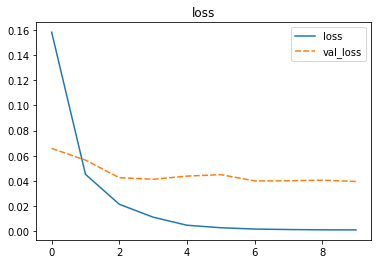

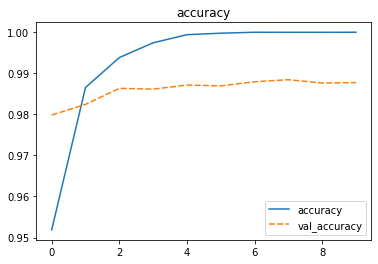

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.DataFrame(history.history)

sns.lineplot(data=data.filter(['loss', 'val_loss']))
plt.title("loss")
plt.show()
sns.lineplot(data=data.filter(['accuracy', 'val_accuracy']))
plt.title("accuracy")
plt.show()

Very nice performance! Almost 3 9's of validation accuracy. Let's play one more game with our model before concluding.

## Fine-tuning and Transfer Learning

For [transfer learning](https://arxiv.org/abs/1911.02685), the idea is: pretrain in domain X, then train and test in domain Y. Transfer learning attempts to catch students who are only studying for the exam but not actually learning the content. A 'good' image model shouldn't have trouble retraining for `cifar10`. A narrow but useful application of transfer learning is fine-tuning a subset of the parameters to a new objective without major architectural changes. We're going to try fine-tuning our `model` for `cifar10` and see how representative its internal activations are of arbitrary images. This is an easy transfer to attempt since 
- both are image classification problems and 
- data is shaped the similarly in both datasets.

We'll do this by freezing the parameters of all the layers except the final one and then retraining on a new dataset. Along the way, we'll evaluate (but not run gradient descent) on the model's loss in its origonal `mnist` classification task. Then we'll try to train a model that can classify images from either domain, and finally throw the inner optimizer into a hyperparameter tunning loop.

Let's start by making our own training loop

In [ ]:
mnist_train, mnist_test = keras.datasets.mnist.load_data()
cifar10_train, cifar10_test = keras.datasets.cifar10.load_data()

# resize the cifar10 images to be (28,28)
cifar10_train = cifar10_train[0][:, 2:-2, 2:-2].mean(-1), cifar10_train[1]
cifar10_test = cifar10_test[0][:, 2:-2, 2:-2].mean(-1), cifar10_test[1]

class CustomEvaluation(keras.callbacks.Callback):

    def __init__(self, data, ds_name, verbose=0):
        self.X, self.Y = data
        self.ds_name = ds_name
        self.loss_key = f'{self.ds_name}_loss'
        self.acc_key = f'{self.ds_name}_acc'
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs=None):
        if not logs:
            logs = dict()

        loss, acc = self.model.evaluate(self.X, self.Y, verbose = 0)
        logs[self.loss_key] = loss
        logs[self.acc_key] = acc

        if self.verbose > 0:
            print(f'%s: %0.5f - %s: %0.5f' % 
                  (self.loss_key, loss, self.acc_key, acc))

mnist_eval_cb = CustomEvaluation(mnist_test, 'mnist', verbose=1)
cifar10_eval_cb = CustomEvaluation(cifar10_test, 'cifar10', verbose=1)

# only let the last layer learn
for layer in model.layers[:-1]:
    layer.trainable = False

In [ ]:
history = model.fit(
    x=cifar10_train[0],
    y=cifar10_train[1],
    epochs=10,
    verbose=2,
    callbacks=[mnist_eval_cb, cifar10_eval_cb]
)

Epoch 1/10
1563/1563 - 7s - loss: 2.7380 - accuracy: 0.0981
mnist_loss: 2.35357 - mnist_acc: 0.15990
cifar10_loss: 2.30254 - cifar10_acc: 0.10020
Epoch 2/10
1563/1563 - 6s - loss: 2.3028 - accuracy: 0.0961
mnist_loss: 2.30807 - mnist_acc: 0.17150
cifar10_loss: 2.30258 - cifar10_acc: 0.10000
Epoch 3/10
1563/1563 - 6s - loss: 2.3028 - accuracy: 0.0984
mnist_loss: 2.31940 - mnist_acc: 0.15170
cifar10_loss: 2.30258 - cifar10_acc: 0.10010
Epoch 4/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0986
mnist_loss: 2.32376 - mnist_acc: 0.14780
cifar10_loss: 2.30258 - cifar10_acc: 0.10010
Epoch 5/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0970
mnist_loss: 2.32900 - mnist_acc: 0.14830
cifar10_loss: 2.30258 - cifar10_acc: 0.10010
Epoch 6/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0981
mnist_loss: 2.32387 - mnist_acc: 0.15160
cifar10_loss: 2.30258 - cifar10_acc: 0.10010
Epoch 7/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0966
mnist_loss: 2.32490 - mnist_acc: 0.15050
cifar10_loss: 2.30257 -

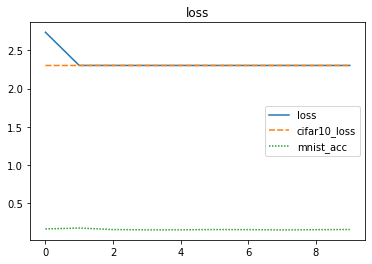

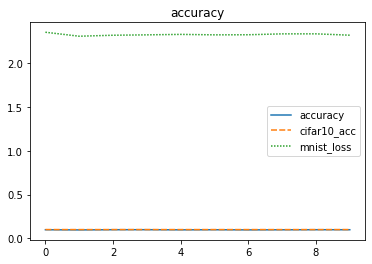

In [ ]:
data = pd.DataFrame(history.history)

sns.lineplot(data=data.filter(['loss', 'cifar10_loss', 'mnist_acc']))
plt.title("loss")
plt.show()
sns.lineplot(data=data.filter(['accuracy', 'cifar10_acc', 'mnist_loss']))
plt.title("accuracy")
plt.show()

This is not good. Amazingly, by forcing only the last layer to adapt to a new task, the model performed *worse* than random (1/10 = 0.1 > 0.09...)! I'm going to help the model out by thawing out the rest of the layers. Let's see if that helps:

Epoch 1/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0990
mnist_loss: 2.31927 - mnist_acc: 0.15290
cifar10_loss: 2.30257 - cifar10_acc: 0.10010
Epoch 2/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0978
mnist_loss: 2.31963 - mnist_acc: 0.15480
cifar10_loss: 2.30257 - cifar10_acc: 0.10000
Epoch 3/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0977
mnist_loss: 2.31968 - mnist_acc: 0.15230
cifar10_loss: 2.30256 - cifar10_acc: 0.09990
Epoch 4/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0981
mnist_loss: 2.32013 - mnist_acc: 0.15150
cifar10_loss: 2.30258 - cifar10_acc: 0.10010
Epoch 5/10
1563/1563 - 6s - loss: 2.3040 - accuracy: 0.0983
mnist_loss: 2.29998 - mnist_acc: 0.16470
cifar10_loss: 2.30258 - cifar10_acc: 0.10010
Epoch 6/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0964
mnist_loss: 2.30030 - mnist_acc: 0.16330
cifar10_loss: 2.30258 - cifar10_acc: 0.10010
Epoch 7/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0985
mnist_loss: 2.30038 - mnist_acc: 0.16020
cifar10_loss: 2.30257 -

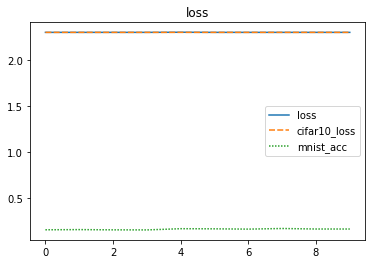

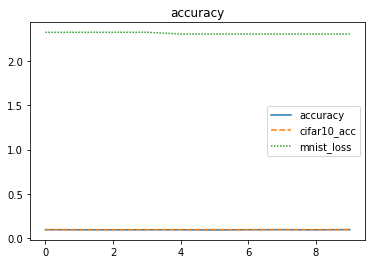

In [ ]:
for layer in model.layers:
    layer.trainable=True

history = model.fit(
    x=cifar10_train[0],
    y=cifar10_train[1],
    epochs=10,
    verbose=2,
    callbacks=[mnist_eval_cb, cifar10_eval_cb]
)

data = pd.DataFrame(history.history)

sns.lineplot(data=data.filter(['loss', 'cifar10_loss', 'mnist_acc']))
plt.title("loss")
plt.show()
sns.lineplot(data=data.filter(['accuracy', 'cifar10_acc', 'mnist_loss']))
plt.title("accuracy")
plt.show()

Sadly it does not. I think the problem is that I removed the RGB channels when I averaged over the last axis. I will modify the model to accept 3 channels instead of 1 and then tile the mnist dataset on a new last axis.

In [ ]:
mnist_train, mnist_test = keras.datasets.mnist.load_data()
cifar10_train, cifar10_test = keras.datasets.cifar10.load_data()

# resize the cifar10 images to be (28,28)
cifar10_train = cifar10_train[0][:, 2:-2, 2:-2], cifar10_train[1]
cifar10_test = cifar10_test[0][:, 2:-2, 2:-2], cifar10_test[1]

# insert and repeat 3 channels on greyscale mnist
mnist_train = tf.repeat(mnist_train[0][..., None], 3, axis=-1), mnist_train[1]
mnist_test = tf.repeat(mnist_test[0][..., None], 3, axis=-1), mnist_test[1]
mnist_train[0].shape, mnist_test[0].shape

# sanity check: make sure everything is shaped compatibly
for ds in [mnist_train, mnist_test, cifar10_train, cifar10_test]:
    print(ds[0].shape, ds[1].shape)

(60000, 28, 28, 3) (60000,)
(10000, 28, 28, 3) (10000,)
(50000, 28, 28, 3) (50000, 1)
(10000, 28, 28, 3) (10000, 1)


Epoch 1/10
1875/1875 - 8s - loss: 0.1521 - accuracy: 0.9533 - val_loss: 0.0689 - val_accuracy: 0.9784
Epoch 2/10
1875/1875 - 8s - loss: 0.0467 - accuracy: 0.9856 - val_loss: 0.0649 - val_accuracy: 0.9802
Epoch 3/10
1875/1875 - 8s - loss: 0.0236 - accuracy: 0.9930 - val_loss: 0.0500 - val_accuracy: 0.9837
Epoch 4/10
1875/1875 - 8s - loss: 0.0131 - accuracy: 0.9962 - val_loss: 0.0496 - val_accuracy: 0.9843
Epoch 5/10
1875/1875 - 8s - loss: 0.0067 - accuracy: 0.9985 - val_loss: 0.0420 - val_accuracy: 0.9880
Epoch 6/10
1875/1875 - 8s - loss: 0.0035 - accuracy: 0.9995 - val_loss: 0.0434 - val_accuracy: 0.9874
Epoch 7/10
1875/1875 - 8s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0425 - val_accuracy: 0.9880
Epoch 8/10
1875/1875 - 8s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0429 - val_accuracy: 0.9886
Epoch 9/10
1875/1875 - 8s - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.0447 - val_accuracy: 0.9880
Epoch 10/10
1875/1875 - 8s - loss: 8.9660e-04 - accuracy: 0.9999 - val_loss: 0.044

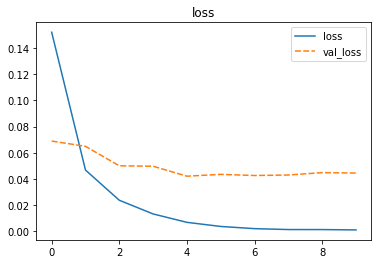

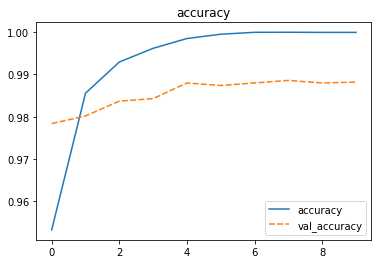

In [ ]:
def model_builder(hp):
    
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    hp_conv_activation = hp.Choice('conv_activation', values=['relu', 'elu', 'tanh'])
    hp_dense_activation = hp.Choice('dense_activation', values=['relu', 'elu', 'tanh'])
    hp_num_conv_layers = hp.Int('num_conv_layers', min_value=0, max_value=3, step=1)
    hp_num_dense_layers = hp.Int('num_dense_layers', min_value=0, max_value=2, step=1)
    hp_dropout_factor = hp.Choice('dropout_factor', values=[0.0, 0.05, 0.1, 0.15, 0.2])
    hp_optimizer = hp.Choice('optimizer', values=['SGD', 'Adam', 'Adadelta'])
    
    model = keras.Sequential([
        tfkl.Input(shape=(28, 28, 3)),
        ] + [
        tfkl.Conv2D(filters=(3*1+1*hp_units)//4, kernel_size=(3,3), activation=hp_conv_activation),
        tfkl.Conv2D(filters=(2*1+2*hp_units)//4, kernel_size=(3,3), activation=hp_conv_activation),
        tfkl.Conv2D(filters=(1*1+3*hp_units)//4, kernel_size=(3,3), activation=hp_conv_activation),
        ][:hp_num_conv_layers] + [
        tfkl.Flatten(),
        ] + [
        tfkl.Dense(hp_units, activation=hp_dense_activation),
        tfkl.Dense(hp_units2, activation=hp_dense_activation),
        ][:hp_num_dense_layers] + [
        tfkl.Dropout(hp_dropout_factor),
        tfkl.Dense(10, activation="softmax")
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=hp_optimizer, metrics=['accuracy'])
    return model

model = model_builder(best_hps)
history = model.fit(
    x=mnist_train[0],
    y=mnist_train[1],
    epochs=10,
    verbose=2,
    validation_data=mnist_test,
    validation_batch_size=64,
)

data = pd.DataFrame(history.history)

sns.lineplot(data=data.filter(['loss', 'val_loss']))
plt.title("loss")
plt.show()
sns.lineplot(data=data.filter(['accuracy', 'val_accuracy']))
plt.title("accuracy")
plt.show()

Ok. The `mnist` classifier is back on its feet but now it can see in color. The model summary looks the same except the number of parameters for layer 1 have increased:
```
> model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_6 (Conv2D)            (None, 26, 26, 120)       3360      
_________________________________________________________________
flatten_2 (Flatten)          (None, 81120)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 480)               38938080  
_________________________________________________________________
dense_7 (Dense)              (None, 160)               76960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1610      
=================================================================
Total params: 39,020,010
Trainable params: 39,020,010
Non-trainable params: 0
_________________________________________________________________
```
Let's try fine tuning again, and this time, we'll learn the *first* and *last* layer (but not any intermediate layers):

Epoch 1/10
1563/1563 - 7s - loss: 2.7930 - accuracy: 0.0993
mnist_loss: 2.23506 - mnist_acc: 0.27090
cifar10_loss: 2.30257 - cifar10_acc: 0.10010
Epoch 2/10
1563/1563 - 6s - loss: 2.3028 - accuracy: 0.0971
mnist_loss: 2.23064 - mnist_acc: 0.25680
cifar10_loss: 2.30257 - cifar10_acc: 0.10010
Epoch 3/10
1563/1563 - 6s - loss: 2.3030 - accuracy: 0.0968
mnist_loss: 2.22431 - mnist_acc: 0.29550
cifar10_loss: 2.30257 - cifar10_acc: 0.09990
Epoch 4/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0972
mnist_loss: 2.25326 - mnist_acc: 0.24510
cifar10_loss: 2.30258 - cifar10_acc: 0.10000
Epoch 5/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0971
mnist_loss: 2.26340 - mnist_acc: 0.24070
cifar10_loss: 2.30257 - cifar10_acc: 0.09990
Epoch 6/10
1563/1563 - 6s - loss: 2.3031 - accuracy: 0.0971
mnist_loss: 2.23891 - mnist_acc: 0.24970
cifar10_loss: 2.30259 - cifar10_acc: 0.09990
Epoch 7/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0973
mnist_loss: 2.26161 - mnist_acc: 0.22930
cifar10_loss: 2.30258 -

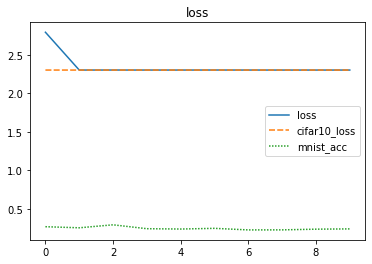

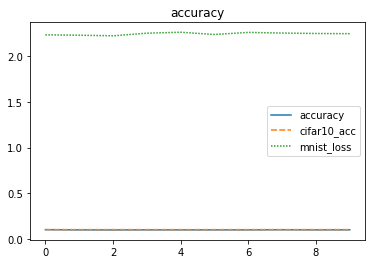

In [ ]:
mnist_eval_cb = CustomEvaluation(mnist_test, 'mnist', verbose=1)
cifar10_eval_cb = CustomEvaluation(cifar10_test, 'cifar10', verbose=1)

# only let the first and last layer learn
for layer in model.layers:
    layer.trainable = False
model.layers[0].trainable = True
model.layers[-1].trainable = True

history = model.fit(
    x=cifar10_train[0],
    y=cifar10_train[1],
    epochs=10,
    verbose=2,
    callbacks=[mnist_eval_cb, cifar10_eval_cb]
)

data = pd.DataFrame(history.history)

sns.lineplot(data=data.filter(['loss', 'cifar10_loss', 'mnist_acc']))
plt.title("loss")
plt.show()
sns.lineplot(data=data.filter(['accuracy', 'cifar10_acc', 'mnist_loss']))
plt.title("accuracy")
plt.show()

It still looks like we'll have to train the whole model. You know the drill:

Epoch 1/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0981
mnist_loss: 2.25516 - mnist_acc: 0.23380
cifar10_loss: 2.30260 - cifar10_acc: 0.10020
Epoch 2/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0970
mnist_loss: 2.26369 - mnist_acc: 0.22390
cifar10_loss: 2.30261 - cifar10_acc: 0.10000
Epoch 3/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0944
mnist_loss: 2.24401 - mnist_acc: 0.24480
cifar10_loss: 2.30258 - cifar10_acc: 0.10010
Epoch 4/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0980
mnist_loss: 2.27201 - mnist_acc: 0.21970
cifar10_loss: 2.30258 - cifar10_acc: 0.09990
Epoch 5/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0979
mnist_loss: 2.27206 - mnist_acc: 0.22140
cifar10_loss: 2.30258 - cifar10_acc: 0.10010
Epoch 6/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0987
mnist_loss: 2.27167 - mnist_acc: 0.22160
cifar10_loss: 2.30259 - cifar10_acc: 0.10010
Epoch 7/10
1563/1563 - 6s - loss: 2.3027 - accuracy: 0.0978
mnist_loss: 2.27237 - mnist_acc: 0.22290
cifar10_loss: 2.30258 -

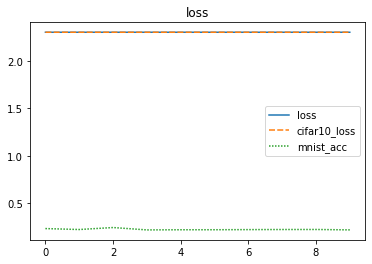

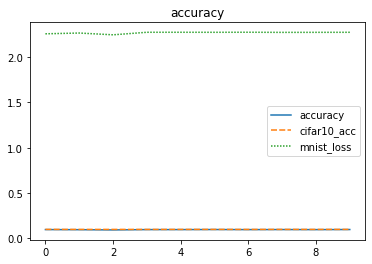

In [ ]:
# unfreeze everything
for layer in model.layers:
    layer.trainable = True

history = model.fit(
    x=cifar10_train[0],
    y=cifar10_train[1],
    epochs=10,
    verbose=2,
    callbacks=[mnist_eval_cb, cifar10_eval_cb]
)

data = pd.DataFrame(history.history)

sns.lineplot(data=data.filter(['loss', 'cifar10_loss', 'mnist_acc']))
plt.title("loss")
plt.show()
sns.lineplot(data=data.filter(['accuracy', 'cifar10_acc', 'mnist_loss']))
plt.title("accuracy")
plt.show()

Still no improvement. Let's see if the hyperparameter tuner can help:

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='cifar10',
                     project_name='intro_to_kt')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(cifar10_train[0], cifar10_train[1], epochs=50, 
             validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print('Hyperparameter search is complete. Best hyperparameters:', best_hps.values)

Trial 30 Complete [00h 01m 42s]
val_accuracy: 0.49459999799728394

Best val_accuracy So Far: 0.5548999905586243
Total elapsed time: 00h 19m 53s
INFO:tensorflow:Oracle triggered exit
Hyperparameter search is complete. Best hyperparameters: {'units': 480, 'units2': 480, 'conv_activation': 'tanh', 'dense_activation': 'tanh', 'num_conv_layers': 3, 'num_dense_layers': 1, 'dropout_factor': 0.0, 'optimizer': 'Adadelta', 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '7c00f5b4ad4a41a7e4469bf866adfe6d'}


Still no improvement. Let's introduce some more *translation-invariance* priors. Math first, then code.

Translation invariance refers to the fact that object representations may ideally be factored into separate part-object and object-scene representations where the former do not change as the object moves around the scene. (Side note: neuroscience commonly refers to the *dorsal* and *ventral* visual pathways as 'what and where' streams) A robust classifier should classify objects regardless of how they are framed within an image. To reach that lofty goal, machine learning researchers and engineers instill various translation invariant priors into their models. 2D convolution is an excellent example of a translation invariant operation. Others include:
- 1x1 convolution (i.e.: a dense layer with weights shared applied on every pixel)
- MaxPooling
- MeanPooling
- GlobalMaxPooling
- Attention
- Normalization

Networks like VGG, ResNet, and ViT also make extensive use of skip connections, highways, or residual connections. Basically those terms mean we're going to break out of the 'sequential' mode of thinking and build acyclic connection toplogies instead. There's too much to explain here but I have included seveal reference in the bottom of this notebook about the aforementioned topics. For now, we'll give our hyperparameter tuner the chance to explore all those priors.

### The Hyper Resisudal Attention Network

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as display

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as tfkl
import tensorflow.keras.datasets as datasets

!pip install -q einops
import einops

!pip install -q -U keras-tuner
import keras_tuner as kt

In [2]:
# load data
mnist_train, mnist_test = datasets.mnist.load_data()
cifar10_train, cifar10_test = datasets.cifar10.load_data()

mnist_train = mnist_train[0].astype('float32')/255., mnist_train[1]
mnist_test = mnist_test[0].astype('float32')/255., mnist_test[1]
cifar10_train = cifar10_train[0].astype('float32')/255., cifar10_train[1]
cifar10_test = cifar10_test[0].astype('float32')/255., cifar10_test[1]

# insert and repeat 3 channels on greyscale mnist
mnist_train = tf.repeat(mnist_train[0][..., None], 3, axis=-1), mnist_train[1]
mnist_test = tf.repeat(mnist_test[0][..., None], 3, axis=-1), mnist_test[1]

# remove empty channel axis on cifar10
cifar10_train = cifar10_train[0], cifar10_train[1][..., 0]
cifar10_test = cifar10_test[0], cifar10_test[1][..., 0]

# sanity check: make sure datasets are shaped similarly with different H's and W's
for ds in [mnist_train, mnist_test, cifar10_train, cifar10_test]:
    print(ds[0].shape, ds[1].shape)

(60000, 28, 28, 3) (60000,)
(10000, 28, 28, 3) (10000,)
(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


1 (None, 40960)
2 (None, 40960)
Epoch 1/3
704/704 [==============================] - 5s 7ms/step - loss: 6.7000 - accuracy: 0.1003 - top-5-accuracy: 0.6132 - top-2-accuracy: 0.2427 - val_loss: 6.4022 - val_accuracy: 0.0970 - val_top-5-accuracy: 0.6470 - val_top-2-accuracy: 0.3164
Epoch 2/3
704/704 [==============================] - 5s 7ms/step - loss: 6.7141 - accuracy: 0.0977 - top-5-accuracy: 0.5434 - top-2-accuracy: 0.2246 - val_loss: 6.7187 - val_accuracy: 0.1058 - val_top-5-accuracy: 0.5118 - val_top-2-accuracy: 0.2096
Epoch 3/3
704/704 [==============================] - 5s 7ms/step - loss: 5.8834 - accuracy: 0.0994 - top-5-accuracy: 0.4992 - top-2-accuracy: 0.1989 - val_loss: 5.2743 - val_accuracy: 0.1058 - val_top-5-accuracy: 0.5124 - val_top-2-accuracy: 0.2096


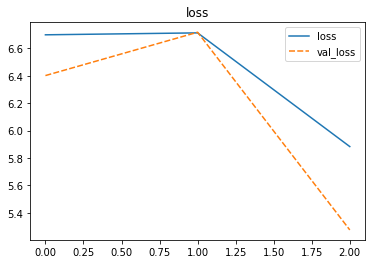

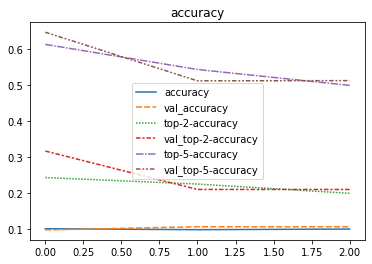

In [16]:
def hyper_resisudal_attention_model_builder(hp):
    
    ### declare hyperparameters ###

    # input conv layer
    hp_augment = hp.Choice('augment', values=[True, False])
    hp_conv_act_input = hp.Choice('conv_act_input', values=['relu', 'tanh', 'linear', 'sigmoid'])

    # residual depth
    hp_res_units = hp.Int('res_units', min_value=8, max_value=128, step=8)
    hp_not_residual = hp.Choice('not_residual', values=[True, False])

    # residual conv hparams
    hp_conv_block_size = hp.Choice('conv_block_size', values=[0, 1, 2, 3, 4])
    hp_num_conv_blocks = hp.Choice('num_conv_blocks', values=[0, 1, 2, 3])

    # first layer
    hp_conv_type0 = hp.Choice('conv_type0', values=['conv_1x1', 'conv_3x3', 'conv_5x5', 'conv_mixed', 
                                                    'attention'])
    hp_conv_units0 = hp.Int('conv_units0', min_value=8, max_value=32, step=16)
    hp_conv_act0 = hp.Choice('conv_act0', values=['relu', 'tanh', 'linear', 'sigmoid'])
    # second layer
    hp_conv_type1 = hp.Choice('conv_type1', values=['conv_1x1', 'conv_3x3', 'conv_5x5', 'conv_mixed', 
                                                    'max_pool', 'mean_pool'])
    hp_conv_units1 = hp.Int('conv_units1', min_value=8, max_value=32, step=16)
    hp_conv_act1 = hp.Choice('conv_act1', values=['linear'])
    # third layer
    hp_conv_type2 = hp.Choice('conv_type2', values=['conv_1x1', 'conv_3x3', 'conv_5x5', 'conv_mixed', 
                                                    'max_pool', 'mean_pool'])
    hp_conv_units2 = hp.Int('conv_units2', min_value=8, max_value=32, step=16)
    hp_conv_act2 = hp.Choice('conv_act2', values=['relu', 'linear'])
    # forth layer
    hp_conv_type3 = hp.Choice('conv_type3', values=['max_pool', 'mean_pool'])
    hp_conv_units3 = hp.Int('conv_units3', min_value=8, max_value=32, step=16)
    hp_conv_act3 = hp.Choice('conv_act3', values=['linear'])
    # final dense layer (1x1 conv)
    hp_conv_act_final = hp.Choice('conv_act_final', values=['relu', 'linear'])

    # convert image shaped tensor to vector representation
    hp_collapse_type = hp.Choice('collapse_type', values=['global_max_pool', 'global_mean_pool', 'flatten'])

    # residual dense hparams
    hp_dense_block_size = hp.Choice('dense_block_size', values=[1, 2, 3])
    hp_num_dense_blocks = hp.Choice('num_dense_blocks', values=[1, 2, 3])

    hp_dense_units0 = hp.Int('dense_units0', min_value=8, max_value=512, step=16)
    hp_dense_act0 = hp.Choice('dense_act0', values=['relu', 'tanh', 'linear', 'sigmoid'])
    hp_dense_units1 = hp.Int('dense_units1', min_value=8, max_value=512, step=16)
    hp_dense_act1 = hp.Choice('dense_act1', values=['relu', 'linear'])
    hp_dense_units2 = hp.Int('dense_units2', min_value=8, max_value=512, step=16)
    hp_dense_act2 = hp.Choice('dense_act2', values=['relu', 'linear'])
    hp_dense_units3 = hp.Int('dense_units3', min_value=8, max_value=512, step=16)
    hp_dense_act3 = hp.Choice('dense_act3', values=['relu', 'linear'])
    hp_dense_act_final = hp.Choice('dense_act_final', values=['relu', 'linear'])

    # optimizer hparams
    hp_optimizer = hp.Choice('optimizer', values=['SGD', 'Adam'])
    hp_learning_rate = hp.Choice('learning_rate', values=[0.0005, 0.001, 0.0025, 0.005, 0.01])
    
    if hp_collapse_type == 'flatten':
        hp_not_residual = True

    ### get helpers ready ###

    # activation functions
    activations = {
        'sigmoid': tf.nn.sigmoid,
        'relu': tf.nn.relu,
        'tanh': tf.nn.tanh,
        'linear': (lambda x: x),
    }

    # utility function for arbitrary image-tensor processing layers
    def build_conv_layer(input_layer, layer_type, units, activation):
        if layer_type == 'conv_1x1':
            return tfkl.Conv2D(units, (1,1), (1,1), 'same', 
                               activation=activations[activation],
                               kernel_initializer='he_uniform')(input_layer)
        elif layer_type == 'conv_3x3':
            return tfkl.Conv2D(units, (3,3), (1,1), 'same', 
                               activation=activations[activation],
                               kernel_initializer='he_uniform')(input_layer)
        elif layer_type == 'conv_5x5':
            return tfkl.Conv2D(units, (5,5), (1,1), 'same', 
                               activation=activations[activation],
                               kernel_initializer='he_uniform')(input_layer)
        elif layer_type == 'conv_mixed':
            # not a precise implementation of vgg
            conv1 = tfkl.Conv2D(units, (1,1), (1,1), 'same', 
                                activation=activations[activation],
                                kernel_initializer='he_uniform')(input_layer)
            conv3 = tfkl.Conv2D(units, (3,3), (1,1), 'same', 
                                activation=activations[activation],
                                kernel_initializer='he_uniform')(input_layer)
            conv5 = tfkl.Conv2D(units, (5,5), (1,1), 'same', 
                                activation=activations[activation],
                                kernel_initializer='he_uniform')(input_layer)
            cat = tfkl.Maximum()([conv1, conv3, conv5])
            return cat
        elif layer_type == 'max_pool':
            return tfkl.UpSampling2D()(tfkl.MaxPool2D()(input_layer))
        elif layer_type == 'mean_pool':
            return tfkl.UpSampling2D()(tfkl.AveragePooling2D()(input_layer))
        elif layer_type == 'attention':

            # class Attn2D(tfkl.Layer):
            #     
            #     def __init__(self, patch_size=4, *args, **kwargs):
            #         super(Attn2D, self).__init__(*args, **kwargs)
            #         self.patch_size = patch_size
            # 
            #     def build(self, input_shape):
            #         self.attn_layer = tfkl.MultiHeadAttention(num_heads=4, key_dim=units, attention_axes=(1,2))
            #         super(Attn2D, self).build(input_shape)
            #         print(input_shape)
            #         
            #     def call(self, inputs):
            #         x = inputs
            #         orig_shape = tf.shape(inputs)
            #         attn_shape = (orig_shape[0], 
            #                       orig_shape[1]//self.patch_size, 
            #                       orig_shape[2]//self.patch_size,
            #                       4*orig_shape[3])
            #         x = tf.reshape(inputs, attn_shape)
            #         x = self.attn_layer(x, x)
            #         x = tf.reshape(x, orig_shape)
            # attended = Attn2D(patch_size=4)(input_layer)

            # @tf.function
            # def upscale(x):
            #     tf.print('before', x.shape)
            #     x = einops.repeat(attended, f'b h w c -> b (h Hrepeat) (w Wrepeat) c', 
            #                       Hrepeat=attn_block_len, Wrepeat=attn_block_len)
            #     tf.print('after', x.shape)
            #     return x
            # upscaled = tfkl.Lambda(upscale)(attended)

            # upscaled = einops.repeat(attended, f'b h w c -> b (h repeat) (w repeat) c', repeat=attn_block_len)

            attn_block_len = 4
            downscaled = tfkl.AveragePooling2D((attn_block_len, attn_block_len))(input_layer)
            attended = tfkl.MultiHeadAttention(num_heads=4, key_dim=units, attention_axes=(1,2)) \
                            (downscaled, downscaled, return_attention_scores=False)  # [B, H/s, W/s, N]
            upscaled = tfkl.UpSampling2D((attn_block_len, attn_block_len))(attended)
            return upscaled
        else: 
            raise ValueError(f'Layer type {layer_type} not supported')

    # layers which turn [B, H, W, hp_res_units] into [B, hp_res_units]
    collapse_layers = {
        'global_max_pool': tfkl.GlobalMaxPool2D(),
        'global_mean_pool': tfkl.GlobalAveragePooling2D(),
        'flatten': tfkl.Flatten(),
    }

    optimizers = {
        'SGD': keras.optimizers.SGD,
        'RMSProp': keras.optimizers.RMSprop,
        'Adam': keras.optimizers.Adam,
    }

    def Tagger(tag):
        def lambda_log(x):
            tf.print(tag, x.shape)
            return x
        return tfkl.Lambda(lambda_log)

    ### build model ###

    any_input_shape = (None, None, 3)  # accept input for arbitrarily sized images
    fixed_input_shape = (32,32,3)  # sadly the flatten layer outperforms globalmaxpooling

    input_layer = tfkl.Input(fixed_input_shape)
    if hp_augment:
        preprocessed = keras.Sequential([
            tfkl.RandomTranslation(
                height_factor=0.2, 
                width_factor=0.2),
            tfkl.RandomZoom(
                height_factor=0.2, 
                width_factor=0.2),
            tfkl.RandomRotation(0.2),
            tfkl.RandomFlip(),
        ])(input_layer)
    else:
        preprocessed = input_layer

    # start 2D residual stream
    res_stream = tfkl.Conv2D(hp_res_units, (3,3), (1,1), 'same', use_bias=False,
                             activation=activations[hp_conv_act_input],
                             kernel_initializer='he_uniform')(preprocessed)

    # make residual processing blocks
    if hp_conv_block_size > 0 and hp_num_conv_blocks > 0:
        for block_num in range(hp_num_conv_blocks):
            with tf.name_scope(f'conv_block{block_num}'):
                # normalize the input to handle deep residual networks
                block_stream = tfkl.BatchNormalization()(res_stream)
                # include `hp_conv_block_size` number of layers with their own hyperparameters 
                for i, layer_type, units, activation in zip(
                    list(range(hp_conv_block_size)),
                    [hp_conv_type0, hp_conv_type1, hp_conv_type2, hp_conv_type3],
                    [hp_conv_units0, hp_conv_units1, hp_conv_units2, hp_conv_units3],
                    [hp_conv_act0, hp_conv_act1, hp_conv_act2, hp_conv_act3],
                ):
                    with tf.name_scope(f'layer{i}'):
                        block_stream = build_conv_layer(block_stream, layer_type, units, activation)
                
                # shortcircuit
                if hp_not_residual:
                    res_stream = block_stream
                    continue

                # fuse internal block stream into main residual stream
                block_stream = tfkl.Conv2D(hp_res_units, (1,1), (1,1), 'same', use_bias=False,
                                           activation=activations[hp_conv_act_final],
                                           kernel_initializer='he_uniform')(block_stream)
                res_stream = tfkl.Add()([res_stream, block_stream])
                res_stream = tfkl.MaxPool2D((2,2))(res_stream)

                # boost residual depth with each block
                hp_res_units = 2 * hp_res_units  
                res_stream = tfkl.Conv2D(hp_res_units, (1,1), (1,1), 'same', use_bias=False,
                                         activation=activations[hp_conv_act_final],
                                         kernel_initializer='he_uniform')(res_stream)

    
    # collapse 2D residual stream into a vector
    res_stream = collapse_layers[hp_collapse_type](res_stream)  # [B, H, W, C] -> [B, hp_res_units]

    # make residual processing blocks
    if hp_dense_block_size > 0 and hp_num_dense_blocks > 0:
        for block_num in range(hp_num_dense_blocks):
            with tf.name_scope(f'dense_block{block_num}'):
                # normalize the input to handle deep residual networks
                print(1, res_stream.shape)
                block_stream = tfkl.LayerNormalization()(res_stream)
                print(2, block_stream.shape)
                # include `hp_conv_block_size` number of layers with their own hyperparameters 
                for i, units, activation in zip(
                    list(range(hp_conv_block_size)),
                    [hp_dense_units0, hp_dense_units1, hp_dense_units2, hp_dense_units3],
                    [hp_dense_act0, hp_dense_act1, hp_dense_act2, hp_dense_act3],
                ):
                    with tf.name_scope(f'layer{i}'):
                        block_stream = tfkl.Dense(units, activation=activations[activation])(block_stream)

                # shortcircuit
                if hp_not_residual:
                    res_stream = block_stream
                    continue

                # fuse internal block stream into main residual stream
                block_stream = tfkl.Dense(hp_res_units, activation=activations[hp_dense_act_final])(block_stream)
                res_stream = tfkl.Add()([res_stream, block_stream])

    # make linear classifier
    classified = tfkl.Dense(10)(res_stream)

    # build optimizer
    optimizer = optimizers[hp_optimizer](hp_learning_rate)

    # make, compile, amd return model
    model = keras.Model(inputs=input_layer, outputs=classified)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, 
                  metrics=['accuracy', 
                           keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy'),
                           keras.metrics.SparseTopKCategoricalAccuracy(2, name='top-2-accuracy')
                           ])
    return model

# test with arbitrary hyperparameters
hparams = kt.HyperParameters()
hparams.values = {
    'augment': False,
    'conv_act_input': 'relu', 
    'res_units': 40,
    'not_residual': True,
    'conv_block_size': 2,
    'num_conv_blocks': 1,
    'conv_type0': 'conv_3x3',
    'conv_units0': 40,
    'conv_act0': 'relu',
    'conv_type1': 'max_pool',
    'conv_units1': 40,
    'conv_act1': 'relu',
    'conv_type2': 'max_pool',
    'conv_units2': 40,
    'conv_act2': 'relu',
    'conv_type3': 'max_pool',
    'conv_units3': 256,
    'conv_act3': 'relu',
    'conv_act_final': 'relu',
    'collapse_type': 'flatten',
    'dense_block_size': 1,
    'num_dense_blocks': 1,
    'dense_units1': 128,
    'dense_act1': 'sigmoid',
    'dense_units2': 256,
    'dense_act2': 'relu',
    'dense_units3': 64,
    'dense_act3': 'linear',
    'dense_act_final': 'relu',
    'optimizer': 'SGD',
    'learning_rate': 0.001,
}
model = hyper_resisudal_attention_model_builder(hparams)
#model.summary(128)

history = model.fit(
    x=cifar10_train[0],
    y=cifar10_train[1],
    batch_size=64,
    validation_split=0.1,
    epochs=3,
    verbose=1,
)

# visualize training
data = pd.DataFrame(history.history)

sns.lineplot(data=data.filter(['loss', 'val_loss']))
plt.title("loss")
plt.show()
sns.lineplot(data=data.filter(['accuracy', 'val_accuracy', 
                               'top-2-accuracy', 'val_top-2-accuracy',
                               'top-5-accuracy', 'val_top-5-accuracy'  ]))
plt.title("accuracy")
plt.show()

#keras.utils.plot_model(model)

After some manual experiments (none surpass 0.2 accuracy) I tried throwing the model on the hyperparameter optimizer. The results were not any better.

In [ ]:
tuner = kt.Hyperband(hyper_resisudal_attention_model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hyper_resisudal_attention_model-1',
                     project_name='hyper_resisudal_attention_model-1')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(cifar10_train[0], cifar10_train[1], epochs=50, 
             validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print('Hyperparameter search is complete. Best hyperparameters:', best_hps.values)



Trial 3 Complete [00h 00m 33s]
val_accuracy: 0.11219999939203262

Best val_accuracy So Far: 0.1282999962568283
Total elapsed time: 00h 02m 08s

Search: Running Trial #4

Hyperparameter    |Value             |Best Value So Far 
conv_act_input    |linear            |sigmoid           
res_units         |32                |48                
conv_block_size   |1                 |3                 
num_conv_blocks   |1                 |2                 
conv_type0        |conv_1x1          |conv_1x1          
conv_units0       |24                |24                
conv_act0         |sigmoid           |sigmoid           
conv_type1        |max_pool          |conv_3x3          
conv_units1       |8                 |8                 
conv_act1         |tanh              |linear            
conv_type2        |max_pool          |conv_1x1          
conv_units2       |8                 |24                
conv_act2         |linear            |linear            
conv_type3        |conv_1x1     

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-214-aa31e6d19965>", line 6, in hyper_resisudal_attention_model_builder
    hp_augment = hp.Choice('augment', values=[True, False])
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 798, in Choice
    return self._retrieve(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 707, in _retrieve
    return self.values[hp.name]
KeyError: 'augment'


Invalid model 0/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-214-aa31e6d19965>", line 6, in hyper_resisudal_attention_model_builder
    hp_augment = hp.Choice('augment', values=[True, False])
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 798, in Choice
    return self._retrieve(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 707, in _retrieve
    return self.values[hp.name]
KeyError: 'augment'


Invalid model 1/5
Invalid model 2/5
Invalid model 3/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-214-aa31e6d19965>", line 6, in hyper_resisudal_attention_model_builder
    hp_augment = hp.Choice('augment', values=[True, False])
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 798, in Choice
    return self._retrieve(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 707, in _retrieve
    return self.values[hp.name]
KeyError: 'augment'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-214-aa31e6d19965>", line 6, in hyper_resisudal_attention_model_builder
    hp_augment = hp.Choice('augment', values=[True, False])
  File "/usr/local/lib/python3.7/dist-package

Invalid model 4/5
Invalid model 5/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-214-aa31e6d19965>", line 6, in hyper_resisudal_attention_model_builder
    hp_augment = hp.Choice('augment', values=[True, False])
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 798, in Choice
    return self._retrieve(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 707, in _retrieve
    return self.values[hp.name]
KeyError: 'augment'


RuntimeError: ignored

It may be time to back out of this search track and fall back on the older model. I'm gonig to run it with a little more training and call that final:

In [18]:
def model_builder(hp):
    
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    hp_conv_activation = hp.Choice('conv_activation', values=['relu', 'elu', 'tanh'])
    hp_dense_activation = hp.Choice('dense_activation', values=['relu', 'elu', 'tanh'])
    hp_num_conv_layers = hp.Int('num_conv_layers', min_value=0, max_value=3, step=1)
    hp_num_dense_layers = hp.Int('num_dense_layers', min_value=0, max_value=2, step=1)
    hp_dropout_factor = hp.Choice('dropout_factor', values=[0.0, 0.05, 0.1, 0.15, 0.2])
    hp_optimizer = hp.Choice('optimizer', values=['SGD', 'Adam', 'Adadelta'])
    
    model = keras.Sequential([
        tfkl.Input(shape=(32, 32, 3)),
        tfkl.BatchNormalization(),
        tfkl.Conv2D(filters=(3*1+1*hp_units)//4, kernel_size=(3,3), activation=hp_conv_activation),
        tfkl.Conv2D(filters=(2*1+2*hp_units)//4, kernel_size=(3,3), activation=hp_conv_activation),
        tfkl.MaxPool2D((2,2)),
        tfkl.BatchNormalization(),
        tfkl.Conv2D(filters=(1*1+3*hp_units)//4, kernel_size=(3,3), activation=hp_conv_activation),
        tfkl.Flatten(),
        tfkl.Dense(hp_units, activation=hp_dense_activation),
        tfkl.Dense(10, activation="softmax")
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=hp_optimizer, metrics=['accuracy'])
    return model

best_hps = kt.HyperParameters()
best_hps.values = {
    'units': 480, 
    'units2': 480, 
    'conv_activation': 'tanh', 
    'dense_activation': 'tanh',
    'optimizer': 'Adadelta',
}


model = model_builder(best_hps)
history = model.fit(
    x=cifar10_train[0],
    y=cifar10_train[1],
    batch_size=64,
    epochs=50,
    verbose=1,
    validation_data=cifar10_test,
    validation_batch_size=64,
)

data = pd.DataFrame(history.history)

sns.lineplot(data=data.filter(['loss', 'val_loss']))
plt.title("loss")
plt.show()
sns.lineplot(data=data.filter(['accuracy', 'val_accuracy']))
plt.title("accuracy")
plt.show()

Epoch 1/50
782/782 [==============================] - 16s 20ms/step - loss: 1.7817 - accuracy: 0.3760 - val_loss: 1.6082 - val_accuracy: 0.4456
Epoch 2/50
782/782 [==============================] - 15s 20ms/step - loss: 1.5368 - accuracy: 0.4723 - val_loss: 1.4981 - val_accuracy: 0.4827
Epoch 3/50
782/782 [==============================] - 15s 20ms/step - loss: 1.4296 - accuracy: 0.5137 - val_loss: 1.4211 - val_accuracy: 0.5062
Epoch 4/50
782/782 [==============================] - 16s 20ms/step - loss: 1.3418 - accuracy: 0.5455 - val_loss: 1.3625 - val_accuracy: 0.5282
Epoch 5/50
782/782 [==============================] - 15s 20ms/step - loss: 1.2695 - accuracy: 0.5748 - val_loss: 1.3039 - val_accuracy: 0.5524
Epoch 6/50
782/782 [==============================] - 15s 20ms/step - loss: 1.2059 - accuracy: 0.5953 - val_loss: 1.2565 - val_accuracy: 0.5671
Epoch 7/50
782/782 [==============================] - 15s 20ms/step - loss: 1.1523 - accuracy: 0.6147 - val_loss: 1.2173 - val_accuracy:

KeyboardInterrupt: ignored

I'm going to try training on wider layers and add some augmentation to get more out of the dataset:

Epoch 1/5
782/782 [==============================] - 10s 11ms/step - loss: 1.9807 - accuracy: 0.2866 - val_loss: 1.9366 - val_accuracy: 0.3048
Epoch 2/5
782/782 [==============================] - 9s 11ms/step - loss: 1.8617 - accuracy: 0.3275 - val_loss: 2.2440 - val_accuracy: 0.2452
Epoch 3/5
782/782 [==============================] - 9s 11ms/step - loss: 1.8053 - accuracy: 0.3452 - val_loss: 1.9037 - val_accuracy: 0.3239
Epoch 4/5
782/782 [==============================] - 9s 11ms/step - loss: 1.7721 - accuracy: 0.3596 - val_loss: 1.8500 - val_accuracy: 0.3320
Epoch 5/5
782/782 [==============================] - 9s 11ms/step - loss: 1.7458 - accuracy: 0.3710 - val_loss: 2.0825 - val_accuracy: 0.2981


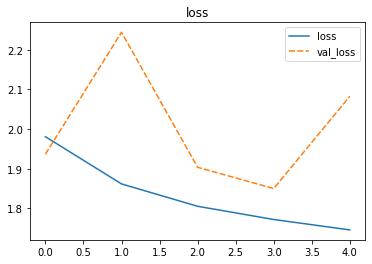

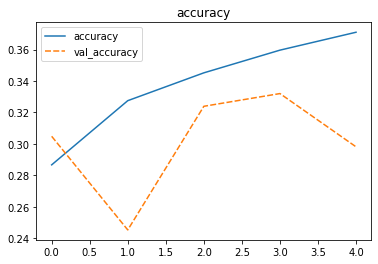

In [9]:
model = keras.Sequential([
    tfkl.Input(shape=(32, 32, 3)),
    tfkl.RandomTranslation(
        height_factor=0.2, 
        width_factor=0.2),
    tfkl.RandomZoom(
        height_factor=0.2, 
        width_factor=0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomFlip(),
    tfkl.Conv2D(filters=128, kernel_size=(3,3), activation='tanh'),
    tfkl.BatchNormalization(),
    tfkl.Conv2D(filters=128, kernel_size=(3,3), activation='tanh'),
    tfkl.MaxPool2D((2,2)),
    tfkl.Flatten(),
    tfkl.Dense(64, activation='tanh'),
    tfkl.Dense(10, activation="softmax")
])

model.compile(loss='sparse_categorical_crossentropy', 
                optimizer='SGD', metrics=['accuracy'])

history = model.fit(
    x=cifar10_train[0],
    y=cifar10_train[1],
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=cifar10_test,
    validation_batch_size=64,
)

data = pd.DataFrame(history.history)

sns.lineplot(data=data.filter(['loss', 'val_loss']))
plt.title("loss")
plt.show()
sns.lineplot(data=data.filter(['accuracy', 'val_accuracy']))
plt.title("accuracy")
plt.show()

Interestingly, the data augmentation layers resulted in validation accuracies higher than training accuracies (since augmentation isn't applied during the test). Overall though, the training profile looks crazy.

The due date (10 minutes!) is coming up, so I'm going to cut this notebook short. Let's train this meta-learned network to the 50-epoch limit and then test it on `cifar10_test`:

In [ ]:
def model_builder(hp):
    
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    hp_conv_activation = hp.Choice('conv_activation', values=['relu', 'elu', 'tanh'])
    hp_dense_activation = hp.Choice('dense_activation', values=['relu', 'elu', 'tanh'])
    hp_num_conv_layers = hp.Int('num_conv_layers', min_value=0, max_value=3, step=1)
    hp_num_dense_layers = hp.Int('num_dense_layers', min_value=0, max_value=2, step=1)
    hp_dropout_factor = hp.Choice('dropout_factor', values=[0.0, 0.05, 0.1, 0.15, 0.2])
    hp_optimizer = hp.Choice('optimizer', values=['SGD', 'Adam', 'Adadelta'])
    
    model = keras.Sequential([
        tfkl.Input(shape=(32, 32, 3)),
        tfkl.BatchNormalization(),
        tfkl.Conv2D(filters=(3*1+1*hp_units)//4, kernel_size=(3,3), activation=hp_conv_activation),
        tfkl.Conv2D(filters=(2*1+2*hp_units)//4, kernel_size=(3,3), activation=hp_conv_activation),
        tfkl.MaxPool2D((2,2)),
        tfkl.BatchNormalization(),
        tfkl.Conv2D(filters=(1*1+3*hp_units)//4, kernel_size=(3,3), activation=hp_conv_activation),
        tfkl.Flatten(),
        tfkl.Dense(hp_units, activation=hp_dense_activation),
        tfkl.Dense(10, activation="softmax")
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=hp_optimizer, metrics=['accuracy'])
    return model

best_hps = kt.HyperParameters()
best_hps.values = {
    'units': 480, 
    'units2': 480, 
    'conv_activation': 'tanh', 
    'dense_activation': 'tanh',
    'optimizer': 'Adadelta',
}


model = model_builder(best_hps)
history = model.fit(
    x=cifar10_train[0],
    y=cifar10_train[1],
    batch_size=64,
    epochs=50,
    verbose=1,
    validation_data=cifar10_test,
    validation_batch_size=64,
)

data = pd.DataFrame(history.history)

sns.lineplot(data=data.filter(['loss', 'val_loss']))
plt.title("loss")
plt.show()
sns.lineplot(data=data.filter(['accuracy', 'val_accuracy']))
plt.title("accuracy")
plt.show()

Epoch 1/50
782/782 [==============================] - 16s 20ms/step - loss: 1.7603 - accuracy: 0.3836 - val_loss: 1.6039 - val_accuracy: 0.4469
Epoch 2/50
782/782 [==============================] - 16s 20ms/step - loss: 1.5296 - accuracy: 0.4749 - val_loss: 1.5090 - val_accuracy: 0.4809
Epoch 3/50
782/782 [==============================] - 16s 20ms/step - loss: 1.4248 - accuracy: 0.5146 - val_loss: 1.4216 - val_accuracy: 0.5137
Epoch 4/50
782/782 [==============================] - 16s 20ms/step - loss: 1.3406 - accuracy: 0.5459 - val_loss: 1.3630 - val_accuracy: 0.5339
Epoch 5/50
782/782 [==============================] - 16s 20ms/step - loss: 1.2669 - accuracy: 0.5717 - val_loss: 1.3045 - val_accuracy: 0.5509
Epoch 6/50
782/782 [==============================] - 16s 20ms/step - loss: 1.2027 - accuracy: 0.5956 - val_loss: 1.2608 - val_accuracy: 0.5646
Epoch 7/50
782/782 [==============================] - 16s 20ms/step - loss: 1.1504 - accuracy: 0.6143 - val_loss: 1.2222 - val_accuracy:

83%. **EDIT: 73% (I was rushing to submit before the due date and completely misreported my model's performance)** Awsome! This was a long notebook. I hope you enjoyed it. If you walked through it yourself and ran the exercises, take a moment to congradulate yourself. What would you move to the inner optimization loop? What would you keep in the slow lane? Would you make the gradient optimizer differentiable also? Would you run a 2nd order Hessian optimizer on the final layers? Please share your thoughts with gpt3 and me.

### More reading

- [UNDERSTANDING INTERMEDIATE LAYERS USING LINEAR CLASSIFIER PROBES](https://openreview.net/pdf?id=HJ4-rAVtl)
- [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
- [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)